In [2]:
import pandas as pd 
import dataparser 
from  math import log
import numpy as np
import pickle
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
from dataparser import *

import folium

pd.set_option('display.max_columns', None)
data=pd.read_csv('_data.csv', index_col=1)

#если цена не в рублях то выбрасываем, цены на доллар и евро сильно меняются, непонятно какая цена в рублях (там всего 27 вариантов)
data=data[data['Цена'].str.contains('руб.')].reset_index()

#убираем всех не из Москвы
data=data[data['Адрес'].str.contains('Москва')].reset_index()

#заполняем пустые места для количества комнат, так как это студии, 1 комната
#фича "Тип" у всех одинаковая, дропаем
data=data.fillna({'Количество комнат':1})\
        .drop('Тип',axis=1)






In [3]:
data

,index,ID объявления,Unnamed: 0,Количество комнат,Метро,Адрес,"Площадь, м2",Дом,Парковка,Цена,Телефоны,Описание,Ремонт,"Площадь комнат, м2",Балкон,Окна,Санузел,Можно с детьми/животными,Дополнительно,Название ЖК,Серия дома,"Высота потолков, м",Лифт,Мусоропровод,Ссылка на объявление
0,0,271271157,0,4,м. Смоленская (9 мин пешком),"Москва, улица Новый Арбат, 27",200.0/20.0,"5/16, Монолитный",подземная,"500000.0 руб./ За месяц, Залог - 500000 руб., ...",+79166369231,Без комиссии для нанимателя! Бонус коллегам 12...,Дизайнерский,NaN,NaN,NaN,NaN,"Можно с детьми, Можно с животными","Мебель в комнатах, Мебель на кухне, Ванна, Душ...","Новый Арбат, 2010",NaN,3.00,"Пасс (4), Груз (1)",Да,https://www.cian.ru/rent/flat/271271157
1,1,271634126,1,4,м. Смоленская (8 мин пешком),"Москва, улица Новый Арбат, 27",198.0/95.0/18.0,"5/16, Монолитно-кирпичный",подземная,"500000.0 руб./ За месяц, Залог - 500000 руб., ...",+79850608590,Лот 93107. Елена Анисимова.\n\nБонус агенту 50...,Дизайнерский,25 25 20 25,NaN,На улицу и двор,"Совмещенный (2), Раздельный (1)",Можно с детьми,"Мебель в комнатах, Мебель на кухне, Ванна, Душ...",Новый Арбат,NaN,3.50,"Пасс (1), Груз (1)",Нет,https://www.cian.ru/rent/flat/271634126
2,2,271173086,2,"4, Оба варианта",м. Смоленская (7 мин пешком),"Москва, улица Новый Арбат, 27",200.0/116.0/4.0,5/16,подземная,"500000.0 руб./ За месяц, Залог - 500000 руб., ...","+79672086536, +79099269384","ID 36380: Шикарная 4-х км. квартира в ЖК ""Нов...",Евроремонт,NaN,NaN,На улицу и двор,Совмещенный (3),Можно с детьми,"Мебель в комнатах, Мебель на кухне, Ванна, Душ...",Новый Арбат,NaN,3.20,Пасс (1),NaN,https://www.cian.ru/rent/flat/271173086
3,3,272197456,3,"4, Оба варианта",м. Смоленская (3 мин пешком),"Москва, переулок Плотников, 21С1",170.0/95.0/17.0,5/6,подземная,"400000.0 руб./ За месяц, Залог - 400000 руб., ...","+79660342340, +79099269384",ID 31618: Эксклюзивное предложение. Современн...,Евроремонт,14-42-20-19,NaN,На улицу и двор,Совмещенный (3),Можно с животными,"Мебель в комнатах, Мебель на кухне, Ванна, Душ...",NaN,NaN,3.20,Пасс (1),NaN,https://www.cian.ru/rent/flat/272197456
4,4,273614615,4,2,м. Арбатская (7 мин пешком),"Москва, улица Новый Арбат, 15",58.0/38.0/5.0,"12/26, Панельный",NaN,"225000.0 руб./ За месяц, Залог - 225000 руб., ...",+79852432860,Лот 111542. Татьяна Лучкина.\n\nБонус агенту 5...,Евроремонт,20 18,NaN,На улицу и двор,Совмещенный (2),NaN,"Мебель в комнатах, Мебель на кухне, Ванна, Душ...",The Book,NaN,3.90,"Пасс (1), Груз (1)",Да,https://www.cian.ru/rent/flat/273614615
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19709,23339,215565511,23363,1,м. Говорово (8 мин пешком),"Москва, Боровское шоссе, 2к7, ш. Боровское (3 ...",35.0/16.4/8.0,10/14,NaN,"42000.0 руб./ За месяц, Залог - 42000 руб., Ко...",+79154383401,Сдаётся светлая теплая квартира (студия) с бал...,Евроремонт,NaN,Балкон (1),NaN,Совмещенный (1),NaN,"Мебель в комнатах, Мебель на кухне, Ванна, Сти...",Мещерский лес,NaN,NaN,"Пасс (1), Груз (1)",NaN,https://www.cian.ru/rent/flat/215565511
19710,23340,274654844,23364,1,м. Солнцево (7 мин пешком),"Москва, Производственная улица, 8к1, ш. Боровс...",38.7/16.5/11.0,"5/18, Монолитный",NaN,"45000.0 руб./ За месяц, Залог - 45000 руб., Ко...",+79151173402,Сдам однокомнатную квартиру на длительный срок...,Евроремонт,NaN,Лоджия (1),Во двор,Совмещенный (1),NaN,"Мебель в комнатах, Мебель на кухне, Ванна, Сти...",Лучи,NaN,NaN,"Пасс (1), Груз (1)",NaN,https://www.cian.ru/rent/flat/274654844
19711,23341,268679909,23365,"2, Оба варианта",м. Солнцево (6 мин пешком),"Москва, Боровский проезд, 11",43.1,"5/5, Кирпичный",NaN,"50000.0 руб./ За месяц, Залог - 50000 руб., Ко...",+79653825192,Рассматриваются квартиранты только славяне и т...,Дизайнерский,NaN,Балкон (1),На улицу и двор,Совмещенный (1),Можно с детьми,"Мебель на кухне, Душевая кабина, Стиральная ма...",NaN,NaN,NaN,NaN,NaN,https://www.cian.ru/rent/flat/268679909
19712,23342,274807525,23366,2,м. Солнцево (11 мин 

In [4]:
def get_col_room(data):
    # Функция для извлечения количества комнат
    return data['Количество комнат'].astype(str).apply(lambda x: int(x[0]))
data['col_rooms'] = get_col_room(data)
data.head(10)

,index,ID объявления,Unnamed: 0,Количество комнат,Метро,Адрес,"Площадь, м2",Дом,Парковка,Цена,Телефоны,Описание,Ремонт,"Площадь комнат, м2",Балкон,Окна,Санузел,Можно с детьми/животными,Дополнительно,Название ЖК,Серия дома,"Высота потолков, м",Лифт,Мусоропровод,Ссылка на объявление,col_rooms
0,0,271271157,0,4,м. Смоленская (9 мин пешком),"Москва, улица Новый Арбат, 27",200.0/20.0,"5/16, Монолитный",подземная,"500000.0 руб./ За месяц, Залог - 500000 руб., ...",+79166369231,Без комиссии для нанимателя! Бонус коллегам 12...,Дизайнерский,NaN,NaN,NaN,NaN,"Можно с детьми, Можно с животными","Мебель в комнатах, Мебель на кухне, Ванна, Душ...","Новый Арбат, 2010",NaN,3.0,"Пасс (4), Груз (1)",Да,https://www.cian.ru/rent/flat/271271157,4
1,1,271634126,1,4,м. Смоленская (8 мин пешком),"Москва, улица Новый Арбат, 27",198.0/95.0/18.0,"5/16, Монолитно-кирпичный",подземная,"500000.0 руб./ За месяц, Залог - 500000 руб., ...",+79850608590,Лот 93107. Елена Анисимова.\n\nБонус агенту 50...,Дизайнерский,25 25 20 25,NaN,На улицу и двор,"Совмещенный (2), Раздельный (1)",Можно с детьми,"Мебель в комнатах, Мебель на кухне, Ванна, Душ...",Новый Арбат,NaN,3.5,"Пасс (1), Груз (1)",Нет,https://www.cian.ru/rent/flat/271634126,4
2,2,271173086,2,"4, Оба варианта",м. Смоленская (7 мин пешком),"Москва, улица Новый Арбат, 27",200.0/116.0/4.0,5/16,подземная,"500000.0 руб./ За месяц, Залог - 500000 руб., ...","+79672086536, +79099269384","ID 36380: Шикарная 4-х км. квартира в ЖК ""Нов...",Евроремонт,NaN,NaN,На улицу и двор,Совмещенный (3),Можно с детьми,"Мебель в комнатах, Мебель на кухне, Ванна, Душ...",Новый Арбат,NaN,3.2,Пасс (1),NaN,https://www.cian.ru/rent/flat/271173086,4
3,3,272197456,3,"4, Оба варианта",м. Смоленская (3 мин пешком),"Москва, переулок Плотников, 21С1",170.0/95.0/17.0,5/6,подземная,"400000.0 руб./ За месяц, Залог - 400000 руб., ...","+79660342340, +79099269384",ID 31618: Эксклюзивное предложение. Современн...,Евроремонт,14-42-20-19,NaN,На улицу и двор,Совмещенный (3),Можно с животными,"Мебель в комнатах, Мебель на кухне, Ванна, Душ...",NaN,NaN,3.2,Пасс (1),NaN,https://www.cian.ru/rent/flat/272197456,4
4,4,273614615,4,2,м. Арбатская (7 мин пешком),"Москва, улица Новый Арбат, 15",58.0/38.0/5.0,"12/26, Панельный",NaN,"225000.0 руб./ За месяц, Залог - 225000 руб., ...",+79852432860,Лот 111542. Татьяна Лучкина.\n\nБонус агенту 5...,Евроремонт,20 18,NaN,На улицу и двор,Совмещенный (2),NaN,"Мебель в комнатах, Мебель на кухне, Ванна, Душ...",The Book,NaN,3.9,"Пасс (1), Груз (1)",Да,https://www.cian.ru/rent/flat/273614615,2
5,5,274837728,5,3,м. Смоленская (5 мин пешком),"Москва, 1-й Смоленский переулок, 21",92.0,3/7,NaN,"470000.0 руб./ За месяц, Залог - 470000 руб., ...",+79684728732,ID 743. С коллегами работаем 50/50. Видовые ап...,Дизайнерский,NaN,NaN,NaN,NaN,NaN,"Мебель в комнатах, Мебель на кухне, Ванна, Душ...",Smolensky De Luxe,NaN,NaN,NaN,NaN,https://www.cian.ru/rent/flat/274837728,3
6,6,273643908,6,"5, Оба варианта",м. Арбатская (4 мин пешком),"Москва, переулок Романов, 3С1",213.0/140.0/20.0,4/5,наземная,"350000.0 руб./ За месяц, Залог - 350000 руб., ...","+79175135482, +79099269384",ID 41980: Предлагается 5-и комнатная квартира...,Евроремонт,43-25-25-25-22,NaN,На улицу и двор,Совмещенный (2),"Можно с детьми, Можно с животными","Мебель в комнатах, Мебель на кухне, Ванна, Сти...",NaN,NaN,3.2,Пасс (1),NaN,https://www.cian.ru/rent/flat/273643908,5
7,7,274475342,7,3,м. Смоленская (3 мин пешком),"Москва, улица Арбат, 43С3",98.0/63.0/9.0,"2/4, Монолитный",подземная,"250000.0 руб./ За месяц, Залог - 250000 руб., ...",+79152004882,Лот 112453. Ирина Панченко.\n\nБонус агенту 40...,Евроремонт,26 22 15,NaN,Во двор,"Совмещенный (1), Раздельный (1)","Можно с детьми, Можно с животными","Мебель в комнатах, Мебель на кухне, Ванна, Душ...",NaN,NaN,3.2,Пасс (1),Нет,https://www.cian.ru/rent/flat/274475342,3
8,8,273973191,8,3,м. Смоленская (9 мин пешком),"Москва, Новинский бульвар, 18С1",120.0/95.0/10.0,"5/10, Сталинский",открытая,"130000.0 руб./ За месяц, Залог

In [5]:
def get_price(data):
    # Функция для извлечения цены
    return data['Цена'].astype(str).apply(lambda x: float(splbac(x,'руб./')[0]))

data['price'] = get_price(data)
data.head(10)

,index,ID объявления,Unnamed: 0,Количество комнат,Метро,Адрес,"Площадь, м2",Дом,Парковка,Цена,Телефоны,Описание,Ремонт,"Площадь комнат, м2",Балкон,Окна,Санузел,Можно с детьми/животными,Дополнительно,Название ЖК,Серия дома,"Высота потолков, м",Лифт,Мусоропровод,Ссылка на объявление,col_rooms,price
0,0,271271157,0,4,м. Смоленская (9 мин пешком),"Москва, улица Новый Арбат, 27",200.0/20.0,"5/16, Монолитный",подземная,"500000.0 руб./ За месяц, Залог - 500000 руб., ...",+79166369231,Без комиссии для нанимателя! Бонус коллегам 12...,Дизайнерский,NaN,NaN,NaN,NaN,"Можно с детьми, Можно с животными","Мебель в комнатах, Мебель на кухне, Ванна, Душ...","Новый Арбат, 2010",NaN,3.0,"Пасс (4), Груз (1)",Да,https://www.cian.ru/rent/flat/271271157,4,500000.0
1,1,271634126,1,4,м. Смоленская (8 мин пешком),"Москва, улица Новый Арбат, 27",198.0/95.0/18.0,"5/16, Монолитно-кирпичный",подземная,"500000.0 руб./ За месяц, Залог - 500000 руб., ...",+79850608590,Лот 93107. Елена Анисимова.\n\nБонус агенту 50...,Дизайнерский,25 25 20 25,NaN,На улицу и двор,"Совмещенный (2), Раздельный (1)",Можно с детьми,"Мебель в комнатах, Мебель на кухне, Ванна, Душ...",Новый Арбат,NaN,3.5,"Пасс (1), Груз (1)",Нет,https://www.cian.ru/rent/flat/271634126,4,500000.0
2,2,271173086,2,"4, Оба варианта",м. Смоленская (7 мин пешком),"Москва, улица Новый Арбат, 27",200.0/116.0/4.0,5/16,подземная,"500000.0 руб./ За месяц, Залог - 500000 руб., ...","+79672086536, +79099269384","ID 36380: Шикарная 4-х км. квартира в ЖК ""Нов...",Евроремонт,NaN,NaN,На улицу и двор,Совмещенный (3),Можно с детьми,"Мебель в комнатах, Мебель на кухне, Ванна, Душ...",Новый Арбат,NaN,3.2,Пасс (1),NaN,https://www.cian.ru/rent/flat/271173086,4,500000.0
3,3,272197456,3,"4, Оба варианта",м. Смоленская (3 мин пешком),"Москва, переулок Плотников, 21С1",170.0/95.0/17.0,5/6,подземная,"400000.0 руб./ За месяц, Залог - 400000 руб., ...","+79660342340, +79099269384",ID 31618: Эксклюзивное предложение. Современн...,Евроремонт,14-42-20-19,NaN,На улицу и двор,Совмещенный (3),Можно с животными,"Мебель в комнатах, Мебель на кухне, Ванна, Душ...",NaN,NaN,3.2,Пасс (1),NaN,https://www.cian.ru/rent/flat/272197456,4,400000.0
4,4,273614615,4,2,м. Арбатская (7 мин пешком),"Москва, улица Новый Арбат, 15",58.0/38.0/5.0,"12/26, Панельный",NaN,"225000.0 руб./ За месяц, Залог - 225000 руб., ...",+79852432860,Лот 111542. Татьяна Лучкина.\n\nБонус агенту 5...,Евроремонт,20 18,NaN,На улицу и двор,Совмещенный (2),NaN,"Мебель в комнатах, Мебель на кухне, Ванна, Душ...",The Book,NaN,3.9,"Пасс (1), Груз (1)",Да,https://www.cian.ru/rent/flat/273614615,2,225000.0
5,5,274837728,5,3,м. Смоленская (5 мин пешком),"Москва, 1-й Смоленский переулок, 21",92.0,3/7,NaN,"470000.0 руб./ За месяц, Залог - 470000 руб., ...",+79684728732,ID 743. С коллегами работаем 50/50. Видовые ап...,Дизайнерский,NaN,NaN,NaN,NaN,NaN,"Мебель в комнатах, Мебель на кухне, Ванна, Душ...",Smolensky De Luxe,NaN,NaN,NaN,NaN,https://www.cian.ru/rent/flat/274837728,3,470000.0
6,6,273643908,6,"5, Оба варианта",м. Арбатская (4 мин пешком),"Москва, переулок Романов, 3С1",213.0/140.0/20.0,4/5,наземная,"350000.0 руб./ За месяц, Залог - 350000 руб., ...","+79175135482, +79099269384",ID 41980: Предлагается 5-и комнатная квартира...,Евроремонт,43-25-25-25-22,NaN,На улицу и двор,Совмещенный (2),"Можно с детьми, Можно с животными","Мебель в комнатах, Мебель на кухне, Ванна, Сти...",NaN,NaN,3.2,Пасс (1),NaN,https://www.cian.ru/rent/flat/273643908,5,350000.0
7,7,274475342,7,3,м. Смоленская (3 мин пешком),"Москва, улица Арбат, 43С3",98.0/63.0/9.0,"2/4, Монолитный",подземная,"250000.0 руб./ За месяц, Залог - 250000 руб., ...",+79152004882,Лот 112453. Ирина Панченко.\n\nБонус агенту 40...,Евроремонт,26 22 15,NaN,Во двор,"Совмещенный (1), Раздельный (1)","Можно с детьми, Можно с животными","Мебель в комнатах, Мебель на кухне, Ванна, Душ...",NaN,NaN,3.2,Пасс (1),Нет,https://www.cian.ru/rent/flat/274475342,3,250000.0
8,8,273973191,8,3,м. Смоленская (9 мин пешком),"Москва, Новинский бульвар, 18С

In [6]:
def get_ceiling_height(data):
    # Функция для извлечения высоты потолков
    return data['Высота потолков, м'].astype(str).apply(lambda x: float(x.split()[0]))

data['ceiling_height'] = get_ceiling_height(data)
data.head(10)

,index,ID объявления,Unnamed: 0,Количество комнат,Метро,Адрес,"Площадь, м2",Дом,Парковка,Цена,Телефоны,Описание,Ремонт,"Площадь комнат, м2",Балкон,Окна,Санузел,Можно с детьми/животными,Дополнительно,Название ЖК,Серия дома,"Высота потолков, м",Лифт,Мусоропровод,Ссылка на объявление,col_rooms,price,ceiling_height
0,0,271271157,0,4,м. Смоленская (9 мин пешком),"Москва, улица Новый Арбат, 27",200.0/20.0,"5/16, Монолитный",подземная,"500000.0 руб./ За месяц, Залог - 500000 руб., ...",+79166369231,Без комиссии для нанимателя! Бонус коллегам 12...,Дизайнерский,NaN,NaN,NaN,NaN,"Можно с детьми, Можно с животными","Мебель в комнатах, Мебель на кухне, Ванна, Душ...","Новый Арбат, 2010",NaN,3.0,"Пасс (4), Груз (1)",Да,https://www.cian.ru/rent/flat/271271157,4,500000.0,3.0
1,1,271634126,1,4,м. Смоленская (8 мин пешком),"Москва, улица Новый Арбат, 27",198.0/95.0/18.0,"5/16, Монолитно-кирпичный",подземная,"500000.0 руб./ За месяц, Залог - 500000 руб., ...",+79850608590,Лот 93107. Елена Анисимова.\n\nБонус агенту 50...,Дизайнерский,25 25 20 25,NaN,На улицу и двор,"Совмещенный (2), Раздельный (1)",Можно с детьми,"Мебель в комнатах, Мебель на кухне, Ванна, Душ...",Новый Арбат,NaN,3.5,"Пасс (1), Груз (1)",Нет,https://www.cian.ru/rent/flat/271634126,4,500000.0,3.5
2,2,271173086,2,"4, Оба варианта",м. Смоленская (7 мин пешком),"Москва, улица Новый Арбат, 27",200.0/116.0/4.0,5/16,подземная,"500000.0 руб./ За месяц, Залог - 500000 руб., ...","+79672086536, +79099269384","ID 36380: Шикарная 4-х км. квартира в ЖК ""Нов...",Евроремонт,NaN,NaN,На улицу и двор,Совмещенный (3),Можно с детьми,"Мебель в комнатах, Мебель на кухне, Ванна, Душ...",Новый Арбат,NaN,3.2,Пасс (1),NaN,https://www.cian.ru/rent/flat/271173086,4,500000.0,3.2
3,3,272197456,3,"4, Оба варианта",м. Смоленская (3 мин пешком),"Москва, переулок Плотников, 21С1",170.0/95.0/17.0,5/6,подземная,"400000.0 руб./ За месяц, Залог - 400000 руб., ...","+79660342340, +79099269384",ID 31618: Эксклюзивное предложение. Современн...,Евроремонт,14-42-20-19,NaN,На улицу и двор,Совмещенный (3),Можно с животными,"Мебель в комнатах, Мебель на кухне, Ванна, Душ...",NaN,NaN,3.2,Пасс (1),NaN,https://www.cian.ru/rent/flat/272197456,4,400000.0,3.2
4,4,273614615,4,2,м. Арбатская (7 мин пешком),"Москва, улица Новый Арбат, 15",58.0/38.0/5.0,"12/26, Панельный",NaN,"225000.0 руб./ За месяц, Залог - 225000 руб., ...",+79852432860,Лот 111542. Татьяна Лучкина.\n\nБонус агенту 5...,Евроремонт,20 18,NaN,На улицу и двор,Совмещенный (2),NaN,"Мебель в комнатах, Мебель на кухне, Ванна, Душ...",The Book,NaN,3.9,"Пасс (1), Груз (1)",Да,https://www.cian.ru/rent/flat/273614615,2,225000.0,3.9
5,5,274837728,5,3,м. Смоленская (5 мин пешком),"Москва, 1-й Смоленский переулок, 21",92.0,3/7,NaN,"470000.0 руб./ За месяц, Залог - 470000 руб., ...",+79684728732,ID 743. С коллегами работаем 50/50. Видовые ап...,Дизайнерский,NaN,NaN,NaN,NaN,NaN,"Мебель в комнатах, Мебель на кухне, Ванна, Душ...",Smolensky De Luxe,NaN,NaN,NaN,NaN,https://www.cian.ru/rent/flat/274837728,3,470000.0,NaN
6,6,273643908,6,"5, Оба варианта",м. Арбатская (4 мин пешком),"Москва, переулок Романов, 3С1",213.0/140.0/20.0,4/5,наземная,"350000.0 руб./ За месяц, Залог - 350000 руб., ...","+79175135482, +79099269384",ID 41980: Предлагается 5-и комнатная квартира...,Евроремонт,43-25-25-25-22,NaN,На улицу и двор,Совмещенный (2),"Можно с детьми, Можно с животными","Мебель в комнатах, Мебель на кухне, Ванна, Сти...",NaN,NaN,3.2,Пасс (1),NaN,https://www.cian.ru/rent/flat/273643908,5,350000.0,3.2
7,7,274475342,7,3,м. Смоленская (3 мин пешком),"Москва, улица Арбат, 43С3",98.0/63.0/9.0,"2/4, Монолитный",подземная,"250000.0 руб./ За месяц, Залог - 250000 руб., ...",+79152004882,Лот 112453. Ирина Панченко.\n\nБонус агенту 40...,Евроремонт,26 22 15,NaN,Во двор,"Совмещенный (1), Раздельный (1)","Можно с детьми, Можно с животными","Мебель в комнатах, Мебель на кухне, Ванна, Душ...",NaN,NaN,3.2,Пасс (1),Нет,https://www.cian.ru/rent/flat/274475342,3,250000.0,3.2
8,8,273973191,8,3,м. Смоленская

In [7]:
def get_var_room_lamb(s):
    # Вспомогательная функция для извлечения варианта комнат
    if ',' in s:
        return s.split(',')[1][1:]

def get_var_room(data):
    # Функция для извлечения варианта комнат
    return data['Количество комнат'].astype(str).apply(get_var_room_lamb)

data['var_room'] = get_var_room(data)
data.head(10)

,index,ID объявления,Unnamed: 0,Количество комнат,Метро,Адрес,"Площадь, м2",Дом,Парковка,Цена,Телефоны,Описание,Ремонт,"Площадь комнат, м2",Балкон,Окна,Санузел,Можно с детьми/животными,Дополнительно,Название ЖК,Серия дома,"Высота потолков, м",Лифт,Мусоропровод,Ссылка на объявление,col_rooms,price,ceiling_height,var_room
0,0,271271157,0,4,м. Смоленская (9 мин пешком),"Москва, улица Новый Арбат, 27",200.0/20.0,"5/16, Монолитный",подземная,"500000.0 руб./ За месяц, Залог - 500000 руб., ...",+79166369231,Без комиссии для нанимателя! Бонус коллегам 12...,Дизайнерский,NaN,NaN,NaN,NaN,"Можно с детьми, Можно с животными","Мебель в комнатах, Мебель на кухне, Ванна, Душ...","Новый Арбат, 2010",NaN,3.0,"Пасс (4), Груз (1)",Да,https://www.cian.ru/rent/flat/271271157,4,500000.0,3.0,None
1,1,271634126,1,4,м. Смоленская (8 мин пешком),"Москва, улица Новый Арбат, 27",198.0/95.0/18.0,"5/16, Монолитно-кирпичный",подземная,"500000.0 руб./ За месяц, Залог - 500000 руб., ...",+79850608590,Лот 93107. Елена Анисимова.\n\nБонус агенту 50...,Дизайнерский,25 25 20 25,NaN,На улицу и двор,"Совмещенный (2), Раздельный (1)",Можно с детьми,"Мебель в комнатах, Мебель на кухне, Ванна, Душ...",Новый Арбат,NaN,3.5,"Пасс (1), Груз (1)",Нет,https://www.cian.ru/rent/flat/271634126,4,500000.0,3.5,None
2,2,271173086,2,"4, Оба варианта",м. Смоленская (7 мин пешком),"Москва, улица Новый Арбат, 27",200.0/116.0/4.0,5/16,подземная,"500000.0 руб./ За месяц, Залог - 500000 руб., ...","+79672086536, +79099269384","ID 36380: Шикарная 4-х км. квартира в ЖК ""Нов...",Евроремонт,NaN,NaN,На улицу и двор,Совмещенный (3),Можно с детьми,"Мебель в комнатах, Мебель на кухне, Ванна, Душ...",Новый Арбат,NaN,3.2,Пасс (1),NaN,https://www.cian.ru/rent/flat/271173086,4,500000.0,3.2,Оба варианта
3,3,272197456,3,"4, Оба варианта",м. Смоленская (3 мин пешком),"Москва, переулок Плотников, 21С1",170.0/95.0/17.0,5/6,подземная,"400000.0 руб./ За месяц, Залог - 400000 руб., ...","+79660342340, +79099269384",ID 31618: Эксклюзивное предложение. Современн...,Евроремонт,14-42-20-19,NaN,На улицу и двор,Совмещенный (3),Можно с животными,"Мебель в комнатах, Мебель на кухне, Ванна, Душ...",NaN,NaN,3.2,Пасс (1),NaN,https://www.cian.ru/rent/flat/272197456,4,400000.0,3.2,Оба варианта
4,4,273614615,4,2,м. Арбатская (7 мин пешком),"Москва, улица Новый Арбат, 15",58.0/38.0/5.0,"12/26, Панельный",NaN,"225000.0 руб./ За месяц, Залог - 225000 руб., ...",+79852432860,Лот 111542. Татьяна Лучкина.\n\nБонус агенту 5...,Евроремонт,20 18,NaN,На улицу и двор,Совмещенный (2),NaN,"Мебель в комнатах, Мебель на кухне, Ванна, Душ...",The Book,NaN,3.9,"Пасс (1), Груз (1)",Да,https://www.cian.ru/rent/flat/273614615,2,225000.0,3.9,None
5,5,274837728,5,3,м. Смоленская (5 мин пешком),"Москва, 1-й Смоленский переулок, 21",92.0,3/7,NaN,"470000.0 руб./ За месяц, Залог - 470000 руб., ...",+79684728732,ID 743. С коллегами работаем 50/50. Видовые ап...,Дизайнерский,NaN,NaN,NaN,NaN,NaN,"Мебель в комнатах, Мебель на кухне, Ванна, Душ...",Smolensky De Luxe,NaN,NaN,NaN,NaN,https://www.cian.ru/rent/flat/274837728,3,470000.0,NaN,None
6,6,273643908,6,"5, Оба варианта",м. Арбатская (4 мин пешком),"Москва, переулок Романов, 3С1",213.0/140.0/20.0,4/5,наземная,"350000.0 руб./ За месяц, Залог - 350000 руб., ...","+79175135482, +79099269384",ID 41980: Предлагается 5-и комнатная квартира...,Евроремонт,43-25-25-25-22,NaN,На улицу и двор,Совмещенный (2),"Можно с детьми, Можно с животными","Мебель в комнатах, Мебель на кухне, Ванна, Сти...",NaN,NaN,3.2,Пасс (1),NaN,https://www.cian.ru/rent/flat/273643908,5,350000.0,3.2,Оба варианта
7,7,274475342,7,3,м. Смоленская (3 мин пешком),"Москва, улица Арбат, 43С3",98.0/63.0/9.0,"2/4, Монолитный",подземная,"250000.0 руб./ За месяц, Залог - 250000 руб., ...",+79152004882,Лот 112453. Ирина Панченко.\n\nБонус агенту 40...,Евроремонт,26 22 15,NaN,Во двор,"Совмещенный (1), Раздельный (1)","Можно с детьми, Можно с животными","Мебель в комнатах, Мебель на кухне, Ванна, Душ...",NaN,NaN,3.2,Пасс (1),Нет,https://www.cian.r

In [8]:
data['metro'] = get_metro(data)

def get_metro_lamb(s):
    # Вспомогательная функция для извлечения метро
    return splfb(s,'м.','(').strip() if s is not None else None

def get_metro(data):
    # Функция для извлечения метро
    return data['Метро'].astype(str).apply(get_metro_lamb)

data.head(10)

,index,ID объявления,Unnamed: 0,Количество комнат,Метро,Адрес,"Площадь, м2",Дом,Парковка,Цена,Телефоны,Описание,Ремонт,"Площадь комнат, м2",Балкон,Окна,Санузел,Можно с детьми/животными,Дополнительно,Название ЖК,Серия дома,"Высота потолков, м",Лифт,Мусоропровод,Ссылка на объявление,col_rooms,price,ceiling_height,var_room,metro
0,0,271271157,0,4,м. Смоленская (9 мин пешком),"Москва, улица Новый Арбат, 27",200.0/20.0,"5/16, Монолитный",подземная,"500000.0 руб./ За месяц, Залог - 500000 руб., ...",+79166369231,Без комиссии для нанимателя! Бонус коллегам 12...,Дизайнерский,NaN,NaN,NaN,NaN,"Можно с детьми, Можно с животными","Мебель в комнатах, Мебель на кухне, Ванна, Душ...","Новый Арбат, 2010",NaN,3.0,"Пасс (4), Груз (1)",Да,https://www.cian.ru/rent/flat/271271157,4,500000.0,3.0,None,Смоленская
1,1,271634126,1,4,м. Смоленская (8 мин пешком),"Москва, улица Новый Арбат, 27",198.0/95.0/18.0,"5/16, Монолитно-кирпичный",подземная,"500000.0 руб./ За месяц, Залог - 500000 руб., ...",+79850608590,Лот 93107. Елена Анисимова.\n\nБонус агенту 50...,Дизайнерский,25 25 20 25,NaN,На улицу и двор,"Совмещенный (2), Раздельный (1)",Можно с детьми,"Мебель в комнатах, Мебель на кухне, Ванна, Душ...",Новый Арбат,NaN,3.5,"Пасс (1), Груз (1)",Нет,https://www.cian.ru/rent/flat/271634126,4,500000.0,3.5,None,Смоленская
2,2,271173086,2,"4, Оба варианта",м. Смоленская (7 мин пешком),"Москва, улица Новый Арбат, 27",200.0/116.0/4.0,5/16,подземная,"500000.0 руб./ За месяц, Залог - 500000 руб., ...","+79672086536, +79099269384","ID 36380: Шикарная 4-х км. квартира в ЖК ""Нов...",Евроремонт,NaN,NaN,На улицу и двор,Совмещенный (3),Можно с детьми,"Мебель в комнатах, Мебель на кухне, Ванна, Душ...",Новый Арбат,NaN,3.2,Пасс (1),NaN,https://www.cian.ru/rent/flat/271173086,4,500000.0,3.2,Оба варианта,Смоленская
3,3,272197456,3,"4, Оба варианта",м. Смоленская (3 мин пешком),"Москва, переулок Плотников, 21С1",170.0/95.0/17.0,5/6,подземная,"400000.0 руб./ За месяц, Залог - 400000 руб., ...","+79660342340, +79099269384",ID 31618: Эксклюзивное предложение. Современн...,Евроремонт,14-42-20-19,NaN,На улицу и двор,Совмещенный (3),Можно с животными,"Мебель в комнатах, Мебель на кухне, Ванна, Душ...",NaN,NaN,3.2,Пасс (1),NaN,https://www.cian.ru/rent/flat/272197456,4,400000.0,3.2,Оба варианта,Смоленская
4,4,273614615,4,2,м. Арбатская (7 мин пешком),"Москва, улица Новый Арбат, 15",58.0/38.0/5.0,"12/26, Панельный",NaN,"225000.0 руб./ За месяц, Залог - 225000 руб., ...",+79852432860,Лот 111542. Татьяна Лучкина.\n\nБонус агенту 5...,Евроремонт,20 18,NaN,На улицу и двор,Совмещенный (2),NaN,"Мебель в комнатах, Мебель на кухне, Ванна, Душ...",The Book,NaN,3.9,"Пасс (1), Груз (1)",Да,https://www.cian.ru/rent/flat/273614615,2,225000.0,3.9,None,Арбатская
5,5,274837728,5,3,м. Смоленская (5 мин пешком),"Москва, 1-й Смоленский переулок, 21",92.0,3/7,NaN,"470000.0 руб./ За месяц, Залог - 470000 руб., ...",+79684728732,ID 743. С коллегами работаем 50/50. Видовые ап...,Дизайнерский,NaN,NaN,NaN,NaN,NaN,"Мебель в комнатах, Мебель на кухне, Ванна, Душ...",Smolensky De Luxe,NaN,NaN,NaN,NaN,https://www.cian.ru/rent/flat/274837728,3,470000.0,NaN,None,Смоленская
6,6,273643908,6,"5, Оба варианта",м. Арбатская (4 мин пешком),"Москва, переулок Романов, 3С1",213.0/140.0/20.0,4/5,наземная,"350000.0 руб./ За месяц, Залог - 350000 руб., ...","+79175135482, +79099269384",ID 41980: Предлагается 5-и комнатная квартира...,Евроремонт,43-25-25-25-22,NaN,На улицу и двор,Совмещенный (2),"Можно с детьми, Можно с животными","Мебель в комнатах, Мебель на кухне, Ванна, Сти...",NaN,NaN,3.2,Пасс (1),NaN,https://www.cian.ru/rent/flat/273643908,5,350000.0,3.2,Оба варианта,Арбатская
7,7,274475342,7,3,м. Смоленская (3 мин пешком),"Москва, улица Арбат, 43С3",98.0/63.0/9.0,"2/4, Монолитный",подземная,"250000.0 руб./ За месяц, Залог - 250000 руб., ...",+79152004882,Лот 112453. Ирина Панченко.\n\nБонус агенту 40...,Евроремонт,26 22 15,NaN,Во двор,"Совмещенный (1), Раздельный (1)","Можно с детьми, Можно с животными","Мебель в комн

In [9]:

def get_metro_time_lamb(s):
    # Вспомогательная функция для извлечения времени до метро
    try:
        if 'пешком'in s:
            return float(splfb(s,'(',' мин').strip() if 'None' not in s else 0)*3 if s is not None or 'nan' else None
        else :
            return float(splfb(s,'(',' мин').strip() if 'None' not in s else 0) if s is not None or 'nan' else None
    except:
        pass

def get_metro_time(data):
    # Функция для извлечения времени до метро
    return data['Метро'].astype(str).apply(get_metro_time_lamb)

data['metro_time'] = get_metro_time(data)
data.head(10)

,index,ID объявления,Unnamed: 0,Количество комнат,Метро,Адрес,"Площадь, м2",Дом,Парковка,Цена,Телефоны,Описание,Ремонт,"Площадь комнат, м2",Балкон,Окна,Санузел,Можно с детьми/животными,Дополнительно,Название ЖК,Серия дома,"Высота потолков, м",Лифт,Мусоропровод,Ссылка на объявление,col_rooms,price,ceiling_height,var_room,metro,metro_time
0,0,271271157,0,4,м. Смоленская (9 мин пешком),"Москва, улица Новый Арбат, 27",200.0/20.0,"5/16, Монолитный",подземная,"500000.0 руб./ За месяц, Залог - 500000 руб., ...",+79166369231,Без комиссии для нанимателя! Бонус коллегам 12...,Дизайнерский,NaN,NaN,NaN,NaN,"Можно с детьми, Можно с животными","Мебель в комнатах, Мебель на кухне, Ванна, Душ...","Новый Арбат, 2010",NaN,3.0,"Пасс (4), Груз (1)",Да,https://www.cian.ru/rent/flat/271271157,4,500000.0,3.0,None,Смоленская,27.0
1,1,271634126,1,4,м. Смоленская (8 мин пешком),"Москва, улица Новый Арбат, 27",198.0/95.0/18.0,"5/16, Монолитно-кирпичный",подземная,"500000.0 руб./ За месяц, Залог - 500000 руб., ...",+79850608590,Лот 93107. Елена Анисимова.\n\nБонус агенту 50...,Дизайнерский,25 25 20 25,NaN,На улицу и двор,"Совмещенный (2), Раздельный (1)",Можно с детьми,"Мебель в комнатах, Мебель на кухне, Ванна, Душ...",Новый Арбат,NaN,3.5,"Пасс (1), Груз (1)",Нет,https://www.cian.ru/rent/flat/271634126,4,500000.0,3.5,None,Смоленская,24.0
2,2,271173086,2,"4, Оба варианта",м. Смоленская (7 мин пешком),"Москва, улица Новый Арбат, 27",200.0/116.0/4.0,5/16,подземная,"500000.0 руб./ За месяц, Залог - 500000 руб., ...","+79672086536, +79099269384","ID 36380: Шикарная 4-х км. квартира в ЖК ""Нов...",Евроремонт,NaN,NaN,На улицу и двор,Совмещенный (3),Можно с детьми,"Мебель в комнатах, Мебель на кухне, Ванна, Душ...",Новый Арбат,NaN,3.2,Пасс (1),NaN,https://www.cian.ru/rent/flat/271173086,4,500000.0,3.2,Оба варианта,Смоленская,21.0
3,3,272197456,3,"4, Оба варианта",м. Смоленская (3 мин пешком),"Москва, переулок Плотников, 21С1",170.0/95.0/17.0,5/6,подземная,"400000.0 руб./ За месяц, Залог - 400000 руб., ...","+79660342340, +79099269384",ID 31618: Эксклюзивное предложение. Современн...,Евроремонт,14-42-20-19,NaN,На улицу и двор,Совмещенный (3),Можно с животными,"Мебель в комнатах, Мебель на кухне, Ванна, Душ...",NaN,NaN,3.2,Пасс (1),NaN,https://www.cian.ru/rent/flat/272197456,4,400000.0,3.2,Оба варианта,Смоленская,9.0
4,4,273614615,4,2,м. Арбатская (7 мин пешком),"Москва, улица Новый Арбат, 15",58.0/38.0/5.0,"12/26, Панельный",NaN,"225000.0 руб./ За месяц, Залог - 225000 руб., ...",+79852432860,Лот 111542. Татьяна Лучкина.\n\nБонус агенту 5...,Евроремонт,20 18,NaN,На улицу и двор,Совмещенный (2),NaN,"Мебель в комнатах, Мебель на кухне, Ванна, Душ...",The Book,NaN,3.9,"Пасс (1), Груз (1)",Да,https://www.cian.ru/rent/flat/273614615,2,225000.0,3.9,None,Арбатская,21.0
5,5,274837728,5,3,м. Смоленская (5 мин пешком),"Москва, 1-й Смоленский переулок, 21",92.0,3/7,NaN,"470000.0 руб./ За месяц, Залог - 470000 руб., ...",+79684728732,ID 743. С коллегами работаем 50/50. Видовые ап...,Дизайнерский,NaN,NaN,NaN,NaN,NaN,"Мебель в комнатах, Мебель на кухне, Ванна, Душ...",Smolensky De Luxe,NaN,NaN,NaN,NaN,https://www.cian.ru/rent/flat/274837728,3,470000.0,NaN,None,Смоленская,15.0
6,6,273643908,6,"5, Оба варианта",м. Арбатская (4 мин пешком),"Москва, переулок Романов, 3С1",213.0/140.0/20.0,4/5,наземная,"350000.0 руб./ За месяц, Залог - 350000 руб., ...","+79175135482, +79099269384",ID 41980: Предлагается 5-и комнатная квартира...,Евроремонт,43-25-25-25-22,NaN,На улицу и двор,Совмещенный (2),"Можно с детьми, Можно с животными","Мебель в комнатах, Мебель на кухне, Ванна, Сти...",NaN,NaN,3.2,Пасс (1),NaN,https://www.cian.ru/rent/flat/273643908,5,350000.0,3.2,Оба варианта,Арбатская,12.0
7,7,274475342,7,3,м. Смоленская (3 мин пешком),"Москва, улица Арбат, 43С3",98.0/63.0/9.0,"2/4, Монолитный",подземная,"250000.0 руб./ За месяц, Залог - 250000 руб., ...",+79152004882,Лот 112453. Ирина Панченко.\n\nБонус агенту 40...,Евроремонт,26 22 15,NaN,Во двор,"Совмещенный (1), Раздельный (1)","Можн

In [10]:
def get_adress_lamb(s):
    # Вспомогательная функция для извлечения адреса
    return s.split(',')[1]

def get_adress(data):
    # Функция для извлечения адреса
    return data['Адрес'].astype(str).apply(get_adress_lamb)


data['adress'] = get_adress(data)
data.head(10)

,index,ID объявления,Unnamed: 0,Количество комнат,Метро,Адрес,"Площадь, м2",Дом,Парковка,Цена,Телефоны,Описание,Ремонт,"Площадь комнат, м2",Балкон,Окна,Санузел,Можно с детьми/животными,Дополнительно,Название ЖК,Серия дома,"Высота потолков, м",Лифт,Мусоропровод,Ссылка на объявление,col_rooms,price,ceiling_height,var_room,metro,metro_time,adress
0,0,271271157,0,4,м. Смоленская (9 мин пешком),"Москва, улица Новый Арбат, 27",200.0/20.0,"5/16, Монолитный",подземная,"500000.0 руб./ За месяц, Залог - 500000 руб., ...",+79166369231,Без комиссии для нанимателя! Бонус коллегам 12...,Дизайнерский,NaN,NaN,NaN,NaN,"Можно с детьми, Можно с животными","Мебель в комнатах, Мебель на кухне, Ванна, Душ...","Новый Арбат, 2010",NaN,3.0,"Пасс (4), Груз (1)",Да,https://www.cian.ru/rent/flat/271271157,4,500000.0,3.0,None,Смоленская,27.0,улица Новый Арбат
1,1,271634126,1,4,м. Смоленская (8 мин пешком),"Москва, улица Новый Арбат, 27",198.0/95.0/18.0,"5/16, Монолитно-кирпичный",подземная,"500000.0 руб./ За месяц, Залог - 500000 руб., ...",+79850608590,Лот 93107. Елена Анисимова.\n\nБонус агенту 50...,Дизайнерский,25 25 20 25,NaN,На улицу и двор,"Совмещенный (2), Раздельный (1)",Можно с детьми,"Мебель в комнатах, Мебель на кухне, Ванна, Душ...",Новый Арбат,NaN,3.5,"Пасс (1), Груз (1)",Нет,https://www.cian.ru/rent/flat/271634126,4,500000.0,3.5,None,Смоленская,24.0,улица Новый Арбат
2,2,271173086,2,"4, Оба варианта",м. Смоленская (7 мин пешком),"Москва, улица Новый Арбат, 27",200.0/116.0/4.0,5/16,подземная,"500000.0 руб./ За месяц, Залог - 500000 руб., ...","+79672086536, +79099269384","ID 36380: Шикарная 4-х км. квартира в ЖК ""Нов...",Евроремонт,NaN,NaN,На улицу и двор,Совмещенный (3),Можно с детьми,"Мебель в комнатах, Мебель на кухне, Ванна, Душ...",Новый Арбат,NaN,3.2,Пасс (1),NaN,https://www.cian.ru/rent/flat/271173086,4,500000.0,3.2,Оба варианта,Смоленская,21.0,улица Новый Арбат
3,3,272197456,3,"4, Оба варианта",м. Смоленская (3 мин пешком),"Москва, переулок Плотников, 21С1",170.0/95.0/17.0,5/6,подземная,"400000.0 руб./ За месяц, Залог - 400000 руб., ...","+79660342340, +79099269384",ID 31618: Эксклюзивное предложение. Современн...,Евроремонт,14-42-20-19,NaN,На улицу и двор,Совмещенный (3),Можно с животными,"Мебель в комнатах, Мебель на кухне, Ванна, Душ...",NaN,NaN,3.2,Пасс (1),NaN,https://www.cian.ru/rent/flat/272197456,4,400000.0,3.2,Оба варианта,Смоленская,9.0,переулок Плотников
4,4,273614615,4,2,м. Арбатская (7 мин пешком),"Москва, улица Новый Арбат, 15",58.0/38.0/5.0,"12/26, Панельный",NaN,"225000.0 руб./ За месяц, Залог - 225000 руб., ...",+79852432860,Лот 111542. Татьяна Лучкина.\n\nБонус агенту 5...,Евроремонт,20 18,NaN,На улицу и двор,Совмещенный (2),NaN,"Мебель в комнатах, Мебель на кухне, Ванна, Душ...",The Book,NaN,3.9,"Пасс (1), Груз (1)",Да,https://www.cian.ru/rent/flat/273614615,2,225000.0,3.9,None,Арбатская,21.0,улица Новый Арбат
5,5,274837728,5,3,м. Смоленская (5 мин пешком),"Москва, 1-й Смоленский переулок, 21",92.0,3/7,NaN,"470000.0 руб./ За месяц, Залог - 470000 руб., ...",+79684728732,ID 743. С коллегами работаем 50/50. Видовые ап...,Дизайнерский,NaN,NaN,NaN,NaN,NaN,"Мебель в комнатах, Мебель на кухне, Ванна, Душ...",Smolensky De Luxe,NaN,NaN,NaN,NaN,https://www.cian.ru/rent/flat/274837728,3,470000.0,NaN,None,Смоленская,15.0,1-й Смоленский переулок
6,6,273643908,6,"5, Оба варианта",м. Арбатская (4 мин пешком),"Москва, переулок Романов, 3С1",213.0/140.0/20.0,4/5,наземная,"350000.0 руб./ За месяц, Залог - 350000 руб., ...","+79175135482, +79099269384",ID 41980: Предлагается 5-и комнатная квартира...,Евроремонт,43-25-25-25-22,NaN,На улицу и двор,Совмещенный (2),"Можно с детьми, Можно с животными","Мебель в комнатах, Мебель на кухне, Ванна, Сти...",NaN,NaN,3.2,Пасс (1),NaN,https://www.cian.ru/rent/flat/273643908,5,350000.0,3.2,Оба варианта,Арбатская,12.0,переулок Романов
7,7,274475342,7,3,м. Смоленская (3 мин пешком),"Москва, улица Арбат, 43С3",98.0/63.0/9.0,"2/4, Монолитный",подземная,"250000.0 руб./ За месяц, Залог - 250000 руб., 

In [11]:
def get_area_lamb(s):
    # Вспомогательная функция для извлечения площади
    if '/'in s:
        return float(splbac(s,'/')[0])
    else:
        return float(s)

def get_area(data):
    # Функция для извлечения площади
    return data['Площадь, м2'].astype(str).apply(get_area_lamb)

data['full_area'] = get_area(data)
data.head(10)

,index,ID объявления,Unnamed: 0,Количество комнат,Метро,Адрес,"Площадь, м2",Дом,Парковка,Цена,Телефоны,Описание,Ремонт,"Площадь комнат, м2",Балкон,Окна,Санузел,Можно с детьми/животными,Дополнительно,Название ЖК,Серия дома,"Высота потолков, м",Лифт,Мусоропровод,Ссылка на объявление,col_rooms,price,ceiling_height,var_room,metro,metro_time,adress,full_area
0,0,271271157,0,4,м. Смоленская (9 мин пешком),"Москва, улица Новый Арбат, 27",200.0/20.0,"5/16, Монолитный",подземная,"500000.0 руб./ За месяц, Залог - 500000 руб., ...",+79166369231,Без комиссии для нанимателя! Бонус коллегам 12...,Дизайнерский,NaN,NaN,NaN,NaN,"Можно с детьми, Можно с животными","Мебель в комнатах, Мебель на кухне, Ванна, Душ...","Новый Арбат, 2010",NaN,3.0,"Пасс (4), Груз (1)",Да,https://www.cian.ru/rent/flat/271271157,4,500000.0,3.0,None,Смоленская,27.0,улица Новый Арбат,200.0
1,1,271634126,1,4,м. Смоленская (8 мин пешком),"Москва, улица Новый Арбат, 27",198.0/95.0/18.0,"5/16, Монолитно-кирпичный",подземная,"500000.0 руб./ За месяц, Залог - 500000 руб., ...",+79850608590,Лот 93107. Елена Анисимова.\n\nБонус агенту 50...,Дизайнерский,25 25 20 25,NaN,На улицу и двор,"Совмещенный (2), Раздельный (1)",Можно с детьми,"Мебель в комнатах, Мебель на кухне, Ванна, Душ...",Новый Арбат,NaN,3.5,"Пасс (1), Груз (1)",Нет,https://www.cian.ru/rent/flat/271634126,4,500000.0,3.5,None,Смоленская,24.0,улица Новый Арбат,198.0
2,2,271173086,2,"4, Оба варианта",м. Смоленская (7 мин пешком),"Москва, улица Новый Арбат, 27",200.0/116.0/4.0,5/16,подземная,"500000.0 руб./ За месяц, Залог - 500000 руб., ...","+79672086536, +79099269384","ID 36380: Шикарная 4-х км. квартира в ЖК ""Нов...",Евроремонт,NaN,NaN,На улицу и двор,Совмещенный (3),Можно с детьми,"Мебель в комнатах, Мебель на кухне, Ванна, Душ...",Новый Арбат,NaN,3.2,Пасс (1),NaN,https://www.cian.ru/rent/flat/271173086,4,500000.0,3.2,Оба варианта,Смоленская,21.0,улица Новый Арбат,200.0
3,3,272197456,3,"4, Оба варианта",м. Смоленская (3 мин пешком),"Москва, переулок Плотников, 21С1",170.0/95.0/17.0,5/6,подземная,"400000.0 руб./ За месяц, Залог - 400000 руб., ...","+79660342340, +79099269384",ID 31618: Эксклюзивное предложение. Современн...,Евроремонт,14-42-20-19,NaN,На улицу и двор,Совмещенный (3),Можно с животными,"Мебель в комнатах, Мебель на кухне, Ванна, Душ...",NaN,NaN,3.2,Пасс (1),NaN,https://www.cian.ru/rent/flat/272197456,4,400000.0,3.2,Оба варианта,Смоленская,9.0,переулок Плотников,170.0
4,4,273614615,4,2,м. Арбатская (7 мин пешком),"Москва, улица Новый Арбат, 15",58.0/38.0/5.0,"12/26, Панельный",NaN,"225000.0 руб./ За месяц, Залог - 225000 руб., ...",+79852432860,Лот 111542. Татьяна Лучкина.\n\nБонус агенту 5...,Евроремонт,20 18,NaN,На улицу и двор,Совмещенный (2),NaN,"Мебель в комнатах, Мебель на кухне, Ванна, Душ...",The Book,NaN,3.9,"Пасс (1), Груз (1)",Да,https://www.cian.ru/rent/flat/273614615,2,225000.0,3.9,None,Арбатская,21.0,улица Новый Арбат,58.0
5,5,274837728,5,3,м. Смоленская (5 мин пешком),"Москва, 1-й Смоленский переулок, 21",92.0,3/7,NaN,"470000.0 руб./ За месяц, Залог - 470000 руб., ...",+79684728732,ID 743. С коллегами работаем 50/50. Видовые ап...,Дизайнерский,NaN,NaN,NaN,NaN,NaN,"Мебель в комнатах, Мебель на кухне, Ванна, Душ...",Smolensky De Luxe,NaN,NaN,NaN,NaN,https://www.cian.ru/rent/flat/274837728,3,470000.0,NaN,None,Смоленская,15.0,1-й Смоленский переулок,92.0
6,6,273643908,6,"5, Оба варианта",м. Арбатская (4 мин пешком),"Москва, переулок Романов, 3С1",213.0/140.0/20.0,4/5,наземная,"350000.0 руб./ За месяц, Залог - 350000 руб., ...","+79175135482, +79099269384",ID 41980: Предлагается 5-и комнатная квартира...,Евроремонт,43-25-25-25-22,NaN,На улицу и двор,Совмещенный (2),"Можно с детьми, Можно с животными","Мебель в комнатах, Мебель на кухне, Ванна, Сти...",NaN,NaN,3.2,Пасс (1),NaN,https://www.cian.ru/rent/flat/273643908,5,350000.0,3.2,Оба варианта,Арбатская,12.0,переулок Романов,213.0
7,7,274475342,7,3,м. Смоленская (3 мин пешком),"Москва, улица Арбат, 43С3",98.0/63.0/9.0,"2/4, Монолитный",подземн

In [12]:
def get_kitchen_area_lamb(s):
    # Вспомогательная функция для извлечения площади кухни
    try:
        if len(s.split('/')) == 2:
            return float(s.split('/')[1])
        
        if len(s.split('/')) == 3:
            return float(s.split('/')[2])
    except:
        print(s.split('/'))

def get_kitchen_area(data):
    # Функция для извлечения площади кухни
    return data['Площадь, м2'].astype(str).apply(get_kitchen_area_lamb)

data['kitchen_area'] = get_kitchen_area(data)
data.head(10)

,index,ID объявления,Unnamed: 0,Количество комнат,Метро,Адрес,"Площадь, м2",Дом,Парковка,Цена,Телефоны,Описание,Ремонт,"Площадь комнат, м2",Балкон,Окна,Санузел,Можно с детьми/животными,Дополнительно,Название ЖК,Серия дома,"Высота потолков, м",Лифт,Мусоропровод,Ссылка на объявление,col_rooms,price,ceiling_height,var_room,metro,metro_time,adress,full_area,kitchen_area
0,0,271271157,0,4,м. Смоленская (9 мин пешком),"Москва, улица Новый Арбат, 27",200.0/20.0,"5/16, Монолитный",подземная,"500000.0 руб./ За месяц, Залог - 500000 руб., ...",+79166369231,Без комиссии для нанимателя! Бонус коллегам 12...,Дизайнерский,NaN,NaN,NaN,NaN,"Можно с детьми, Можно с животными","Мебель в комнатах, Мебель на кухне, Ванна, Душ...","Новый Арбат, 2010",NaN,3.0,"Пасс (4), Груз (1)",Да,https://www.cian.ru/rent/flat/271271157,4,500000.0,3.0,None,Смоленская,27.0,улица Новый Арбат,200.0,20.0
1,1,271634126,1,4,м. Смоленская (8 мин пешком),"Москва, улица Новый Арбат, 27",198.0/95.0/18.0,"5/16, Монолитно-кирпичный",подземная,"500000.0 руб./ За месяц, Залог - 500000 руб., ...",+79850608590,Лот 93107. Елена Анисимова.\n\nБонус агенту 50...,Дизайнерский,25 25 20 25,NaN,На улицу и двор,"Совмещенный (2), Раздельный (1)",Можно с детьми,"Мебель в комнатах, Мебель на кухне, Ванна, Душ...",Новый Арбат,NaN,3.5,"Пасс (1), Груз (1)",Нет,https://www.cian.ru/rent/flat/271634126,4,500000.0,3.5,None,Смоленская,24.0,улица Новый Арбат,198.0,18.0
2,2,271173086,2,"4, Оба варианта",м. Смоленская (7 мин пешком),"Москва, улица Новый Арбат, 27",200.0/116.0/4.0,5/16,подземная,"500000.0 руб./ За месяц, Залог - 500000 руб., ...","+79672086536, +79099269384","ID 36380: Шикарная 4-х км. квартира в ЖК ""Нов...",Евроремонт,NaN,NaN,На улицу и двор,Совмещенный (3),Можно с детьми,"Мебель в комнатах, Мебель на кухне, Ванна, Душ...",Новый Арбат,NaN,3.2,Пасс (1),NaN,https://www.cian.ru/rent/flat/271173086,4,500000.0,3.2,Оба варианта,Смоленская,21.0,улица Новый Арбат,200.0,4.0
3,3,272197456,3,"4, Оба варианта",м. Смоленская (3 мин пешком),"Москва, переулок Плотников, 21С1",170.0/95.0/17.0,5/6,подземная,"400000.0 руб./ За месяц, Залог - 400000 руб., ...","+79660342340, +79099269384",ID 31618: Эксклюзивное предложение. Современн...,Евроремонт,14-42-20-19,NaN,На улицу и двор,Совмещенный (3),Можно с животными,"Мебель в комнатах, Мебель на кухне, Ванна, Душ...",NaN,NaN,3.2,Пасс (1),NaN,https://www.cian.ru/rent/flat/272197456,4,400000.0,3.2,Оба варианта,Смоленская,9.0,переулок Плотников,170.0,17.0
4,4,273614615,4,2,м. Арбатская (7 мин пешком),"Москва, улица Новый Арбат, 15",58.0/38.0/5.0,"12/26, Панельный",NaN,"225000.0 руб./ За месяц, Залог - 225000 руб., ...",+79852432860,Лот 111542. Татьяна Лучкина.\n\nБонус агенту 5...,Евроремонт,20 18,NaN,На улицу и двор,Совмещенный (2),NaN,"Мебель в комнатах, Мебель на кухне, Ванна, Душ...",The Book,NaN,3.9,"Пасс (1), Груз (1)",Да,https://www.cian.ru/rent/flat/273614615,2,225000.0,3.9,None,Арбатская,21.0,улица Новый Арбат,58.0,5.0
5,5,274837728,5,3,м. Смоленская (5 мин пешком),"Москва, 1-й Смоленский переулок, 21",92.0,3/7,NaN,"470000.0 руб./ За месяц, Залог - 470000 руб., ...",+79684728732,ID 743. С коллегами работаем 50/50. Видовые ап...,Дизайнерский,NaN,NaN,NaN,NaN,NaN,"Мебель в комнатах, Мебель на кухне, Ванна, Душ...",Smolensky De Luxe,NaN,NaN,NaN,NaN,https://www.cian.ru/rent/flat/274837728,3,470000.0,NaN,None,Смоленская,15.0,1-й Смоленский переулок,92.0,NaN
6,6,273643908,6,"5, Оба варианта",м. Арбатская (4 мин пешком),"Москва, переулок Романов, 3С1",213.0/140.0/20.0,4/5,наземная,"350000.0 руб./ За месяц, Залог - 350000 руб., ...","+79175135482, +79099269384",ID 41980: Предлагается 5-и комнатная квартира...,Евроремонт,43-25-25-25-22,NaN,На улицу и двор,Совмещенный (2),"Можно с детьми, Можно с животными","Мебель в комнатах, Мебель на кухне, Ванна, Сти...",NaN,NaN,3.2,Пасс (1),NaN,https://www.cian.ru/rent/flat/273643908,5,350000.0,3.2,Оба варианта,Арбатская,12.0,переулок Романов,213.0,20.0
7,7,274475342,7,3,м. Смоленская (3 мин пешком),"Москва, улица Арбат, 

In [13]:

def get_living_area_lamb(s):
    # Вспомогательная функция для извлечения жилой площади
    if len(s.split('/')) == 3:
        return float(s.split('/')[1])

def get_living_area(data):
    # Функция для извлечения жилой площади
    return data['Площадь, м2'].astype(str).apply(get_living_area_lamb)

data['living_area'] = get_living_area(data)
data.head(10)

,index,ID объявления,Unnamed: 0,Количество комнат,Метро,Адрес,"Площадь, м2",Дом,Парковка,Цена,Телефоны,Описание,Ремонт,"Площадь комнат, м2",Балкон,Окна,Санузел,Можно с детьми/животными,Дополнительно,Название ЖК,Серия дома,"Высота потолков, м",Лифт,Мусоропровод,Ссылка на объявление,col_rooms,price,ceiling_height,var_room,metro,metro_time,adress,full_area,kitchen_area,living_area
0,0,271271157,0,4,м. Смоленская (9 мин пешком),"Москва, улица Новый Арбат, 27",200.0/20.0,"5/16, Монолитный",подземная,"500000.0 руб./ За месяц, Залог - 500000 руб., ...",+79166369231,Без комиссии для нанимателя! Бонус коллегам 12...,Дизайнерский,NaN,NaN,NaN,NaN,"Можно с детьми, Можно с животными","Мебель в комнатах, Мебель на кухне, Ванна, Душ...","Новый Арбат, 2010",NaN,3.0,"Пасс (4), Груз (1)",Да,https://www.cian.ru/rent/flat/271271157,4,500000.0,3.0,None,Смоленская,27.0,улица Новый Арбат,200.0,20.0,NaN
1,1,271634126,1,4,м. Смоленская (8 мин пешком),"Москва, улица Новый Арбат, 27",198.0/95.0/18.0,"5/16, Монолитно-кирпичный",подземная,"500000.0 руб./ За месяц, Залог - 500000 руб., ...",+79850608590,Лот 93107. Елена Анисимова.\n\nБонус агенту 50...,Дизайнерский,25 25 20 25,NaN,На улицу и двор,"Совмещенный (2), Раздельный (1)",Можно с детьми,"Мебель в комнатах, Мебель на кухне, Ванна, Душ...",Новый Арбат,NaN,3.5,"Пасс (1), Груз (1)",Нет,https://www.cian.ru/rent/flat/271634126,4,500000.0,3.5,None,Смоленская,24.0,улица Новый Арбат,198.0,18.0,95.0
2,2,271173086,2,"4, Оба варианта",м. Смоленская (7 мин пешком),"Москва, улица Новый Арбат, 27",200.0/116.0/4.0,5/16,подземная,"500000.0 руб./ За месяц, Залог - 500000 руб., ...","+79672086536, +79099269384","ID 36380: Шикарная 4-х км. квартира в ЖК ""Нов...",Евроремонт,NaN,NaN,На улицу и двор,Совмещенный (3),Можно с детьми,"Мебель в комнатах, Мебель на кухне, Ванна, Душ...",Новый Арбат,NaN,3.2,Пасс (1),NaN,https://www.cian.ru/rent/flat/271173086,4,500000.0,3.2,Оба варианта,Смоленская,21.0,улица Новый Арбат,200.0,4.0,116.0
3,3,272197456,3,"4, Оба варианта",м. Смоленская (3 мин пешком),"Москва, переулок Плотников, 21С1",170.0/95.0/17.0,5/6,подземная,"400000.0 руб./ За месяц, Залог - 400000 руб., ...","+79660342340, +79099269384",ID 31618: Эксклюзивное предложение. Современн...,Евроремонт,14-42-20-19,NaN,На улицу и двор,Совмещенный (3),Можно с животными,"Мебель в комнатах, Мебель на кухне, Ванна, Душ...",NaN,NaN,3.2,Пасс (1),NaN,https://www.cian.ru/rent/flat/272197456,4,400000.0,3.2,Оба варианта,Смоленская,9.0,переулок Плотников,170.0,17.0,95.0
4,4,273614615,4,2,м. Арбатская (7 мин пешком),"Москва, улица Новый Арбат, 15",58.0/38.0/5.0,"12/26, Панельный",NaN,"225000.0 руб./ За месяц, Залог - 225000 руб., ...",+79852432860,Лот 111542. Татьяна Лучкина.\n\nБонус агенту 5...,Евроремонт,20 18,NaN,На улицу и двор,Совмещенный (2),NaN,"Мебель в комнатах, Мебель на кухне, Ванна, Душ...",The Book,NaN,3.9,"Пасс (1), Груз (1)",Да,https://www.cian.ru/rent/flat/273614615,2,225000.0,3.9,None,Арбатская,21.0,улица Новый Арбат,58.0,5.0,38.0
5,5,274837728,5,3,м. Смоленская (5 мин пешком),"Москва, 1-й Смоленский переулок, 21",92.0,3/7,NaN,"470000.0 руб./ За месяц, Залог - 470000 руб., ...",+79684728732,ID 743. С коллегами работаем 50/50. Видовые ап...,Дизайнерский,NaN,NaN,NaN,NaN,NaN,"Мебель в комнатах, Мебель на кухне, Ванна, Душ...",Smolensky De Luxe,NaN,NaN,NaN,NaN,https://www.cian.ru/rent/flat/274837728,3,470000.0,NaN,None,Смоленская,15.0,1-й Смоленский переулок,92.0,NaN,NaN
6,6,273643908,6,"5, Оба варианта",м. Арбатская (4 мин пешком),"Москва, переулок Романов, 3С1",213.0/140.0/20.0,4/5,наземная,"350000.0 руб./ За месяц, Залог - 350000 руб., ...","+79175135482, +79099269384",ID 41980: Предлагается 5-и комнатная квартира...,Евроремонт,43-25-25-25-22,NaN,На улицу и двор,Совмещенный (2),"Можно с детьми, Можно с животными","Мебель в комнатах, Мебель на кухне, Ванна, Сти...",NaN,NaN,3.2,Пасс (1),NaN,https://www.cian.ru/rent/flat/273643908,5,350000.0,3.2,Оба варианта,Арбатская,12.0,переулок Романов,213.0,20.0,140.0
7,7,274475342,7,3,м. С

In [14]:
def get_floor_lamb(s):
    # Вспомогательная функция для извлечения этажа
    return float(s.split('/')[0])

def get_floor(data):
    # Функция для извлечения этажа
    return data['Дом'].astype(str).apply(get_floor_lamb)


data['floor'] = get_floor(data)
data.head(10)

,index,ID объявления,Unnamed: 0,Количество комнат,Метро,Адрес,"Площадь, м2",Дом,Парковка,Цена,Телефоны,Описание,Ремонт,"Площадь комнат, м2",Балкон,Окна,Санузел,Можно с детьми/животными,Дополнительно,Название ЖК,Серия дома,"Высота потолков, м",Лифт,Мусоропровод,Ссылка на объявление,col_rooms,price,ceiling_height,var_room,metro,metro_time,adress,full_area,kitchen_area,living_area,floor
0,0,271271157,0,4,м. Смоленская (9 мин пешком),"Москва, улица Новый Арбат, 27",200.0/20.0,"5/16, Монолитный",подземная,"500000.0 руб./ За месяц, Залог - 500000 руб., ...",+79166369231,Без комиссии для нанимателя! Бонус коллегам 12...,Дизайнерский,NaN,NaN,NaN,NaN,"Можно с детьми, Можно с животными","Мебель в комнатах, Мебель на кухне, Ванна, Душ...","Новый Арбат, 2010",NaN,3.0,"Пасс (4), Груз (1)",Да,https://www.cian.ru/rent/flat/271271157,4,500000.0,3.0,None,Смоленская,27.0,улица Новый Арбат,200.0,20.0,NaN,5.0
1,1,271634126,1,4,м. Смоленская (8 мин пешком),"Москва, улица Новый Арбат, 27",198.0/95.0/18.0,"5/16, Монолитно-кирпичный",подземная,"500000.0 руб./ За месяц, Залог - 500000 руб., ...",+79850608590,Лот 93107. Елена Анисимова.\n\nБонус агенту 50...,Дизайнерский,25 25 20 25,NaN,На улицу и двор,"Совмещенный (2), Раздельный (1)",Можно с детьми,"Мебель в комнатах, Мебель на кухне, Ванна, Душ...",Новый Арбат,NaN,3.5,"Пасс (1), Груз (1)",Нет,https://www.cian.ru/rent/flat/271634126,4,500000.0,3.5,None,Смоленская,24.0,улица Новый Арбат,198.0,18.0,95.0,5.0
2,2,271173086,2,"4, Оба варианта",м. Смоленская (7 мин пешком),"Москва, улица Новый Арбат, 27",200.0/116.0/4.0,5/16,подземная,"500000.0 руб./ За месяц, Залог - 500000 руб., ...","+79672086536, +79099269384","ID 36380: Шикарная 4-х км. квартира в ЖК ""Нов...",Евроремонт,NaN,NaN,На улицу и двор,Совмещенный (3),Можно с детьми,"Мебель в комнатах, Мебель на кухне, Ванна, Душ...",Новый Арбат,NaN,3.2,Пасс (1),NaN,https://www.cian.ru/rent/flat/271173086,4,500000.0,3.2,Оба варианта,Смоленская,21.0,улица Новый Арбат,200.0,4.0,116.0,5.0
3,3,272197456,3,"4, Оба варианта",м. Смоленская (3 мин пешком),"Москва, переулок Плотников, 21С1",170.0/95.0/17.0,5/6,подземная,"400000.0 руб./ За месяц, Залог - 400000 руб., ...","+79660342340, +79099269384",ID 31618: Эксклюзивное предложение. Современн...,Евроремонт,14-42-20-19,NaN,На улицу и двор,Совмещенный (3),Можно с животными,"Мебель в комнатах, Мебель на кухне, Ванна, Душ...",NaN,NaN,3.2,Пасс (1),NaN,https://www.cian.ru/rent/flat/272197456,4,400000.0,3.2,Оба варианта,Смоленская,9.0,переулок Плотников,170.0,17.0,95.0,5.0
4,4,273614615,4,2,м. Арбатская (7 мин пешком),"Москва, улица Новый Арбат, 15",58.0/38.0/5.0,"12/26, Панельный",NaN,"225000.0 руб./ За месяц, Залог - 225000 руб., ...",+79852432860,Лот 111542. Татьяна Лучкина.\n\nБонус агенту 5...,Евроремонт,20 18,NaN,На улицу и двор,Совмещенный (2),NaN,"Мебель в комнатах, Мебель на кухне, Ванна, Душ...",The Book,NaN,3.9,"Пасс (1), Груз (1)",Да,https://www.cian.ru/rent/flat/273614615,2,225000.0,3.9,None,Арбатская,21.0,улица Новый Арбат,58.0,5.0,38.0,12.0
5,5,274837728,5,3,м. Смоленская (5 мин пешком),"Москва, 1-й Смоленский переулок, 21",92.0,3/7,NaN,"470000.0 руб./ За месяц, Залог - 470000 руб., ...",+79684728732,ID 743. С коллегами работаем 50/50. Видовые ап...,Дизайнерский,NaN,NaN,NaN,NaN,NaN,"Мебель в комнатах, Мебель на кухне, Ванна, Душ...",Smolensky De Luxe,NaN,NaN,NaN,NaN,https://www.cian.ru/rent/flat/274837728,3,470000.0,NaN,None,Смоленская,15.0,1-й Смоленский переулок,92.0,NaN,NaN,3.0
6,6,273643908,6,"5, Оба варианта",м. Арбатская (4 мин пешком),"Москва, переулок Романов, 3С1",213.0/140.0/20.0,4/5,наземная,"350000.0 руб./ За месяц, Залог - 350000 руб., ...","+79175135482, +79099269384",ID 41980: Предлагается 5-и комнатная квартира...,Евроремонт,43-25-25-25-22,NaN,На улицу и двор,Совмещенный (2),"Можно с детьми, Можно с животными","Мебель в комнатах, Мебель на кухне, Ванна, Сти...",NaN,NaN,3.2,Пасс (1),NaN,https://www.cian.ru/rent/flat/273643908,5,350000.0,3.2,Оба варианта,Арбатская,12.0,переулок Романов,213.0,20

In [15]:

def get_num_floors_lamb(s):
    # Вспомогательная функция для извлечения количества этажей
    if ',' in s:
        return float(s.split(',')[0].split('/')[1])
    else:
        return float(s.split('/')[1])

def get_num_floors(data):
    # Функция для извлечения количества этажей
    return data['Дом'].astype(str).apply(get_num_floors_lamb)

data['num_floors'] = get_num_floors(data)
data.head(10)

,index,ID объявления,Unnamed: 0,Количество комнат,Метро,Адрес,"Площадь, м2",Дом,Парковка,Цена,Телефоны,Описание,Ремонт,"Площадь комнат, м2",Балкон,Окна,Санузел,Можно с детьми/животными,Дополнительно,Название ЖК,Серия дома,"Высота потолков, м",Лифт,Мусоропровод,Ссылка на объявление,col_rooms,price,ceiling_height,var_room,metro,metro_time,adress,full_area,kitchen_area,living_area,floor,num_floors
0,0,271271157,0,4,м. Смоленская (9 мин пешком),"Москва, улица Новый Арбат, 27",200.0/20.0,"5/16, Монолитный",подземная,"500000.0 руб./ За месяц, Залог - 500000 руб., ...",+79166369231,Без комиссии для нанимателя! Бонус коллегам 12...,Дизайнерский,NaN,NaN,NaN,NaN,"Можно с детьми, Можно с животными","Мебель в комнатах, Мебель на кухне, Ванна, Душ...","Новый Арбат, 2010",NaN,3.0,"Пасс (4), Груз (1)",Да,https://www.cian.ru/rent/flat/271271157,4,500000.0,3.0,None,Смоленская,27.0,улица Новый Арбат,200.0,20.0,NaN,5.0,16.0
1,1,271634126,1,4,м. Смоленская (8 мин пешком),"Москва, улица Новый Арбат, 27",198.0/95.0/18.0,"5/16, Монолитно-кирпичный",подземная,"500000.0 руб./ За месяц, Залог - 500000 руб., ...",+79850608590,Лот 93107. Елена Анисимова.\n\nБонус агенту 50...,Дизайнерский,25 25 20 25,NaN,На улицу и двор,"Совмещенный (2), Раздельный (1)",Можно с детьми,"Мебель в комнатах, Мебель на кухне, Ванна, Душ...",Новый Арбат,NaN,3.5,"Пасс (1), Груз (1)",Нет,https://www.cian.ru/rent/flat/271634126,4,500000.0,3.5,None,Смоленская,24.0,улица Новый Арбат,198.0,18.0,95.0,5.0,16.0
2,2,271173086,2,"4, Оба варианта",м. Смоленская (7 мин пешком),"Москва, улица Новый Арбат, 27",200.0/116.0/4.0,5/16,подземная,"500000.0 руб./ За месяц, Залог - 500000 руб., ...","+79672086536, +79099269384","ID 36380: Шикарная 4-х км. квартира в ЖК ""Нов...",Евроремонт,NaN,NaN,На улицу и двор,Совмещенный (3),Можно с детьми,"Мебель в комнатах, Мебель на кухне, Ванна, Душ...",Новый Арбат,NaN,3.2,Пасс (1),NaN,https://www.cian.ru/rent/flat/271173086,4,500000.0,3.2,Оба варианта,Смоленская,21.0,улица Новый Арбат,200.0,4.0,116.0,5.0,16.0
3,3,272197456,3,"4, Оба варианта",м. Смоленская (3 мин пешком),"Москва, переулок Плотников, 21С1",170.0/95.0/17.0,5/6,подземная,"400000.0 руб./ За месяц, Залог - 400000 руб., ...","+79660342340, +79099269384",ID 31618: Эксклюзивное предложение. Современн...,Евроремонт,14-42-20-19,NaN,На улицу и двор,Совмещенный (3),Можно с животными,"Мебель в комнатах, Мебель на кухне, Ванна, Душ...",NaN,NaN,3.2,Пасс (1),NaN,https://www.cian.ru/rent/flat/272197456,4,400000.0,3.2,Оба варианта,Смоленская,9.0,переулок Плотников,170.0,17.0,95.0,5.0,6.0
4,4,273614615,4,2,м. Арбатская (7 мин пешком),"Москва, улица Новый Арбат, 15",58.0/38.0/5.0,"12/26, Панельный",NaN,"225000.0 руб./ За месяц, Залог - 225000 руб., ...",+79852432860,Лот 111542. Татьяна Лучкина.\n\nБонус агенту 5...,Евроремонт,20 18,NaN,На улицу и двор,Совмещенный (2),NaN,"Мебель в комнатах, Мебель на кухне, Ванна, Душ...",The Book,NaN,3.9,"Пасс (1), Груз (1)",Да,https://www.cian.ru/rent/flat/273614615,2,225000.0,3.9,None,Арбатская,21.0,улица Новый Арбат,58.0,5.0,38.0,12.0,26.0
5,5,274837728,5,3,м. Смоленская (5 мин пешком),"Москва, 1-й Смоленский переулок, 21",92.0,3/7,NaN,"470000.0 руб./ За месяц, Залог - 470000 руб., ...",+79684728732,ID 743. С коллегами работаем 50/50. Видовые ап...,Дизайнерский,NaN,NaN,NaN,NaN,NaN,"Мебель в комнатах, Мебель на кухне, Ванна, Душ...",Smolensky De Luxe,NaN,NaN,NaN,NaN,https://www.cian.ru/rent/flat/274837728,3,470000.0,NaN,None,Смоленская,15.0,1-й Смоленский переулок,92.0,NaN,NaN,3.0,7.0
6,6,273643908,6,"5, Оба варианта",м. Арбатская (4 мин пешком),"Москва, переулок Романов, 3С1",213.0/140.0/20.0,4/5,наземная,"350000.0 руб./ За месяц, Залог - 350000 руб., ...","+79175135482, +79099269384",ID 41980: Предлагается 5-и комнатная квартира...,Евроремонт,43-25-25-25-22,NaN,На улицу и двор,Совмещенный (2),"Можно с детьми, Можно с животными","Мебель в комнатах, Мебель на кухне, Ванна, Сти...",NaN,NaN,3.2,Пасс (1),NaN,https://www.cian.ru/rent/flat/273643908,5,350000.0,3.2,Оба варианта,А

In [16]:
data['parking'] = data['Парковка']

data.head(10)

,index,ID объявления,Unnamed: 0,Количество комнат,Метро,Адрес,"Площадь, м2",Дом,Парковка,Цена,Телефоны,Описание,Ремонт,"Площадь комнат, м2",Балкон,Окна,Санузел,Можно с детьми/животными,Дополнительно,Название ЖК,Серия дома,"Высота потолков, м",Лифт,Мусоропровод,Ссылка на объявление,col_rooms,price,ceiling_height,var_room,metro,metro_time,adress,full_area,kitchen_area,living_area,floor,num_floors,parking
0,0,271271157,0,4,м. Смоленская (9 мин пешком),"Москва, улица Новый Арбат, 27",200.0/20.0,"5/16, Монолитный",подземная,"500000.0 руб./ За месяц, Залог - 500000 руб., ...",+79166369231,Без комиссии для нанимателя! Бонус коллегам 12...,Дизайнерский,NaN,NaN,NaN,NaN,"Можно с детьми, Можно с животными","Мебель в комнатах, Мебель на кухне, Ванна, Душ...","Новый Арбат, 2010",NaN,3.0,"Пасс (4), Груз (1)",Да,https://www.cian.ru/rent/flat/271271157,4,500000.0,3.0,None,Смоленская,27.0,улица Новый Арбат,200.0,20.0,NaN,5.0,16.0,подземная
1,1,271634126,1,4,м. Смоленская (8 мин пешком),"Москва, улица Новый Арбат, 27",198.0/95.0/18.0,"5/16, Монолитно-кирпичный",подземная,"500000.0 руб./ За месяц, Залог - 500000 руб., ...",+79850608590,Лот 93107. Елена Анисимова.\n\nБонус агенту 50...,Дизайнерский,25 25 20 25,NaN,На улицу и двор,"Совмещенный (2), Раздельный (1)",Можно с детьми,"Мебель в комнатах, Мебель на кухне, Ванна, Душ...",Новый Арбат,NaN,3.5,"Пасс (1), Груз (1)",Нет,https://www.cian.ru/rent/flat/271634126,4,500000.0,3.5,None,Смоленская,24.0,улица Новый Арбат,198.0,18.0,95.0,5.0,16.0,подземная
2,2,271173086,2,"4, Оба варианта",м. Смоленская (7 мин пешком),"Москва, улица Новый Арбат, 27",200.0/116.0/4.0,5/16,подземная,"500000.0 руб./ За месяц, Залог - 500000 руб., ...","+79672086536, +79099269384","ID 36380: Шикарная 4-х км. квартира в ЖК ""Нов...",Евроремонт,NaN,NaN,На улицу и двор,Совмещенный (3),Можно с детьми,"Мебель в комнатах, Мебель на кухне, Ванна, Душ...",Новый Арбат,NaN,3.2,Пасс (1),NaN,https://www.cian.ru/rent/flat/271173086,4,500000.0,3.2,Оба варианта,Смоленская,21.0,улица Новый Арбат,200.0,4.0,116.0,5.0,16.0,подземная
3,3,272197456,3,"4, Оба варианта",м. Смоленская (3 мин пешком),"Москва, переулок Плотников, 21С1",170.0/95.0/17.0,5/6,подземная,"400000.0 руб./ За месяц, Залог - 400000 руб., ...","+79660342340, +79099269384",ID 31618: Эксклюзивное предложение. Современн...,Евроремонт,14-42-20-19,NaN,На улицу и двор,Совмещенный (3),Можно с животными,"Мебель в комнатах, Мебель на кухне, Ванна, Душ...",NaN,NaN,3.2,Пасс (1),NaN,https://www.cian.ru/rent/flat/272197456,4,400000.0,3.2,Оба варианта,Смоленская,9.0,переулок Плотников,170.0,17.0,95.0,5.0,6.0,подземная
4,4,273614615,4,2,м. Арбатская (7 мин пешком),"Москва, улица Новый Арбат, 15",58.0/38.0/5.0,"12/26, Панельный",NaN,"225000.0 руб./ За месяц, Залог - 225000 руб., ...",+79852432860,Лот 111542. Татьяна Лучкина.\n\nБонус агенту 5...,Евроремонт,20 18,NaN,На улицу и двор,Совмещенный (2),NaN,"Мебель в комнатах, Мебель на кухне, Ванна, Душ...",The Book,NaN,3.9,"Пасс (1), Груз (1)",Да,https://www.cian.ru/rent/flat/273614615,2,225000.0,3.9,None,Арбатская,21.0,улица Новый Арбат,58.0,5.0,38.0,12.0,26.0,NaN
5,5,274837728,5,3,м. Смоленская (5 мин пешком),"Москва, 1-й Смоленский переулок, 21",92.0,3/7,NaN,"470000.0 руб./ За месяц, Залог - 470000 руб., ...",+79684728732,ID 743. С коллегами работаем 50/50. Видовые ап...,Дизайнерский,NaN,NaN,NaN,NaN,NaN,"Мебель в комнатах, Мебель на кухне, Ванна, Душ...",Smolensky De Luxe,NaN,NaN,NaN,NaN,https://www.cian.ru/rent/flat/274837728,3,470000.0,NaN,None,Смоленская,15.0,1-й Смоленский переулок,92.0,NaN,NaN,3.0,7.0,NaN
6,6,273643908,6,"5, Оба варианта",м. Арбатская (4 мин пешком),"Москва, переулок Романов, 3С1",213.0/140.0/20.0,4/5,наземная,"350000.0 руб./ За месяц, Залог - 350000 руб., ...","+79175135482, +79099269384",ID 41980: Предлагается 5-и комнатная квартира...,Евроремонт,43-25-25-25-22,NaN,На улицу и двор,Совмещенный (2),"Можно с детьми, Можно с животными","Мебель в комнатах, Мебель на кухне, Ванна, Сти...",NaN,NaN,3.2,Пасс (1),NaN,https://www.c

In [17]:
def get_prolonged(data):
    # Функция для извлечения признака "Длительный"
    return data['Цена'].apply(lambda x: 'Длительный' if 'Длительный' in x  else '')

data['prolonged'] = get_prolonged(data)
data.head(10)

,index,ID объявления,Unnamed: 0,Количество комнат,Метро,Адрес,"Площадь, м2",Дом,Парковка,Цена,Телефоны,Описание,Ремонт,"Площадь комнат, м2",Балкон,Окна,Санузел,Можно с детьми/животными,Дополнительно,Название ЖК,Серия дома,"Высота потолков, м",Лифт,Мусоропровод,Ссылка на объявление,col_rooms,price,ceiling_height,var_room,metro,metro_time,adress,full_area,kitchen_area,living_area,floor,num_floors,parking,prolonged
0,0,271271157,0,4,м. Смоленская (9 мин пешком),"Москва, улица Новый Арбат, 27",200.0/20.0,"5/16, Монолитный",подземная,"500000.0 руб./ За месяц, Залог - 500000 руб., ...",+79166369231,Без комиссии для нанимателя! Бонус коллегам 12...,Дизайнерский,NaN,NaN,NaN,NaN,"Можно с детьми, Можно с животными","Мебель в комнатах, Мебель на кухне, Ванна, Душ...","Новый Арбат, 2010",NaN,3.0,"Пасс (4), Груз (1)",Да,https://www.cian.ru/rent/flat/271271157,4,500000.0,3.0,None,Смоленская,27.0,улица Новый Арбат,200.0,20.0,NaN,5.0,16.0,подземная,Длительный
1,1,271634126,1,4,м. Смоленская (8 мин пешком),"Москва, улица Новый Арбат, 27",198.0/95.0/18.0,"5/16, Монолитно-кирпичный",подземная,"500000.0 руб./ За месяц, Залог - 500000 руб., ...",+79850608590,Лот 93107. Елена Анисимова.\n\nБонус агенту 50...,Дизайнерский,25 25 20 25,NaN,На улицу и двор,"Совмещенный (2), Раздельный (1)",Можно с детьми,"Мебель в комнатах, Мебель на кухне, Ванна, Душ...",Новый Арбат,NaN,3.5,"Пасс (1), Груз (1)",Нет,https://www.cian.ru/rent/flat/271634126,4,500000.0,3.5,None,Смоленская,24.0,улица Новый Арбат,198.0,18.0,95.0,5.0,16.0,подземная,Длительный
2,2,271173086,2,"4, Оба варианта",м. Смоленская (7 мин пешком),"Москва, улица Новый Арбат, 27",200.0/116.0/4.0,5/16,подземная,"500000.0 руб./ За месяц, Залог - 500000 руб., ...","+79672086536, +79099269384","ID 36380: Шикарная 4-х км. квартира в ЖК ""Нов...",Евроремонт,NaN,NaN,На улицу и двор,Совмещенный (3),Можно с детьми,"Мебель в комнатах, Мебель на кухне, Ванна, Душ...",Новый Арбат,NaN,3.2,Пасс (1),NaN,https://www.cian.ru/rent/flat/271173086,4,500000.0,3.2,Оба варианта,Смоленская,21.0,улица Новый Арбат,200.0,4.0,116.0,5.0,16.0,подземная,Длительный
3,3,272197456,3,"4, Оба варианта",м. Смоленская (3 мин пешком),"Москва, переулок Плотников, 21С1",170.0/95.0/17.0,5/6,подземная,"400000.0 руб./ За месяц, Залог - 400000 руб., ...","+79660342340, +79099269384",ID 31618: Эксклюзивное предложение. Современн...,Евроремонт,14-42-20-19,NaN,На улицу и двор,Совмещенный (3),Можно с животными,"Мебель в комнатах, Мебель на кухне, Ванна, Душ...",NaN,NaN,3.2,Пасс (1),NaN,https://www.cian.ru/rent/flat/272197456,4,400000.0,3.2,Оба варианта,Смоленская,9.0,переулок Плотников,170.0,17.0,95.0,5.0,6.0,подземная,Длительный
4,4,273614615,4,2,м. Арбатская (7 мин пешком),"Москва, улица Новый Арбат, 15",58.0/38.0/5.0,"12/26, Панельный",NaN,"225000.0 руб./ За месяц, Залог - 225000 руб., ...",+79852432860,Лот 111542. Татьяна Лучкина.\n\nБонус агенту 5...,Евроремонт,20 18,NaN,На улицу и двор,Совмещенный (2),NaN,"Мебель в комнатах, Мебель на кухне, Ванна, Душ...",The Book,NaN,3.9,"Пасс (1), Груз (1)",Да,https://www.cian.ru/rent/flat/273614615,2,225000.0,3.9,None,Арбатская,21.0,улица Новый Арбат,58.0,5.0,38.0,12.0,26.0,NaN,Длительный
5,5,274837728,5,3,м. Смоленская (5 мин пешком),"Москва, 1-й Смоленский переулок, 21",92.0,3/7,NaN,"470000.0 руб./ За месяц, Залог - 470000 руб., ...",+79684728732,ID 743. С коллегами работаем 50/50. Видовые ап...,Дизайнерский,NaN,NaN,NaN,NaN,NaN,"Мебель в комнатах, Мебель на кухне, Ванна, Душ...",Smolensky De Luxe,NaN,NaN,NaN,NaN,https://www.cian.ru/rent/flat/274837728,3,470000.0,NaN,None,Смоленская,15.0,1-й Смоленский переулок,92.0,NaN,NaN,3.0,7.0,NaN,Длительный
6,6,273643908,6,"5, Оба варианта",м. Арбатская (4 мин пешком),"Москва, переулок Романов, 3С1",213.0/140.0/20.0,4/5,наземная,"350000.0 руб./ За месяц, Залог - 350000 руб., ...","+79175135482, +79099269384",ID 41980: Предлагается 5-и комнатная квартира...,Евроремонт,43-25-25-25-22,NaN,На улицу и двор,Совмещенный (2),"Можно с детьми, Можно с животными","Мебель в комн

In [18]:
def get_phonenum(data):
    # Функция для извлечения телефона
    v = data['Телефоны'].value_counts()
    return data['Телефоны'].astype(str).apply(lambda x: log(v[x], 2))

data['phone_number'] = get_phonenum(data)
data.head(10)

,index,ID объявления,Unnamed: 0,Количество комнат,Метро,Адрес,"Площадь, м2",Дом,Парковка,Цена,Телефоны,Описание,Ремонт,"Площадь комнат, м2",Балкон,Окна,Санузел,Можно с детьми/животными,Дополнительно,Название ЖК,Серия дома,"Высота потолков, м",Лифт,Мусоропровод,Ссылка на объявление,col_rooms,price,ceiling_height,var_room,metro,metro_time,adress,full_area,kitchen_area,living_area,floor,num_floors,parking,prolonged,phone_number
0,0,271271157,0,4,м. Смоленская (9 мин пешком),"Москва, улица Новый Арбат, 27",200.0/20.0,"5/16, Монолитный",подземная,"500000.0 руб./ За месяц, Залог - 500000 руб., ...",+79166369231,Без комиссии для нанимателя! Бонус коллегам 12...,Дизайнерский,NaN,NaN,NaN,NaN,"Можно с детьми, Можно с животными","Мебель в комнатах, Мебель на кухне, Ванна, Душ...","Новый Арбат, 2010",NaN,3.0,"Пасс (4), Груз (1)",Да,https://www.cian.ru/rent/flat/271271157,4,500000.0,3.0,None,Смоленская,27.0,улица Новый Арбат,200.0,20.0,NaN,5.0,16.0,подземная,Длительный,3.700440
1,1,271634126,1,4,м. Смоленская (8 мин пешком),"Москва, улица Новый Арбат, 27",198.0/95.0/18.0,"5/16, Монолитно-кирпичный",подземная,"500000.0 руб./ За месяц, Залог - 500000 руб., ...",+79850608590,Лот 93107. Елена Анисимова.\n\nБонус агенту 50...,Дизайнерский,25 25 20 25,NaN,На улицу и двор,"Совмещенный (2), Раздельный (1)",Можно с детьми,"Мебель в комнатах, Мебель на кухне, Ванна, Душ...",Новый Арбат,NaN,3.5,"Пасс (1), Груз (1)",Нет,https://www.cian.ru/rent/flat/271634126,4,500000.0,3.5,None,Смоленская,24.0,улица Новый Арбат,198.0,18.0,95.0,5.0,16.0,подземная,Длительный,4.087463
2,2,271173086,2,"4, Оба варианта",м. Смоленская (7 мин пешком),"Москва, улица Новый Арбат, 27",200.0/116.0/4.0,5/16,подземная,"500000.0 руб./ За месяц, Залог - 500000 руб., ...","+79672086536, +79099269384","ID 36380: Шикарная 4-х км. квартира в ЖК ""Нов...",Евроремонт,NaN,NaN,На улицу и двор,Совмещенный (3),Можно с детьми,"Мебель в комнатах, Мебель на кухне, Ванна, Душ...",Новый Арбат,NaN,3.2,Пасс (1),NaN,https://www.cian.ru/rent/flat/271173086,4,500000.0,3.2,Оба варианта,Смоленская,21.0,улица Новый Арбат,200.0,4.0,116.0,5.0,16.0,подземная,Длительный,3.459432
3,3,272197456,3,"4, Оба варианта",м. Смоленская (3 мин пешком),"Москва, переулок Плотников, 21С1",170.0/95.0/17.0,5/6,подземная,"400000.0 руб./ За месяц, Залог - 400000 руб., ...","+79660342340, +79099269384",ID 31618: Эксклюзивное предложение. Современн...,Евроремонт,14-42-20-19,NaN,На улицу и двор,Совмещенный (3),Можно с животными,"Мебель в комнатах, Мебель на кухне, Ванна, Душ...",NaN,NaN,3.2,Пасс (1),NaN,https://www.cian.ru/rent/flat/272197456,4,400000.0,3.2,Оба варианта,Смоленская,9.0,переулок Плотников,170.0,17.0,95.0,5.0,6.0,подземная,Длительный,3.321928
4,4,273614615,4,2,м. Арбатская (7 мин пешком),"Москва, улица Новый Арбат, 15",58.0/38.0/5.0,"12/26, Панельный",NaN,"225000.0 руб./ За месяц, Залог - 225000 руб., ...",+79852432860,Лот 111542. Татьяна Лучкина.\n\nБонус агенту 5...,Евроремонт,20 18,NaN,На улицу и двор,Совмещенный (2),NaN,"Мебель в комнатах, Мебель на кухне, Ванна, Душ...",The Book,NaN,3.9,"Пасс (1), Груз (1)",Да,https://www.cian.ru/rent/flat/273614615,2,225000.0,3.9,None,Арбатская,21.0,улица Новый Арбат,58.0,5.0,38.0,12.0,26.0,NaN,Длительный,4.523562
5,5,274837728,5,3,м. Смоленская (5 мин пешком),"Москва, 1-й Смоленский переулок, 21",92.0,3/7,NaN,"470000.0 руб./ За месяц, Залог - 470000 руб., ...",+79684728732,ID 743. С коллегами работаем 50/50. Видовые ап...,Дизайнерский,NaN,NaN,NaN,NaN,NaN,"Мебель в комнатах, Мебель на кухне, Ванна, Душ...",Smolensky De Luxe,NaN,NaN,NaN,NaN,https://www.cian.ru/rent/flat/274837728,3,470000.0,NaN,None,Смоленская,15.0,1-й Смоленский переулок,92.0,NaN,NaN,3.0,7.0,NaN,Длительный,4.000000
6,6,273643908,6,"5, Оба варианта",м. Арбатская (4 мин пешком),"Москва, переулок Романов, 3С1",213.0/140.0/20.0,4/5,наземная,"350000.0 руб./ За месяц, Залог - 350000 руб., ...","+79175135482, +79099269384",ID 41980: Предлагается 5-и комнатная квартира...,Евроремонт,43-25-25-25-22,NaN,На улицу и двор

In [19]:
def get_coord_y( data):
    # Функция для  определения координат по адресу

    with open('coordinates', 'rb') as file:
        addrdic = pickle.load(file)

    return  data['adress'].apply(lambda x: addrdic[x][0] if addrdic[x] is not None  else None )

def get_coord_x( data):
    # Функция для  определения координат по адресу

    with open('coordinates', 'rb') as file:
        addrdic = pickle.load(file)
    return  data['adress'].apply(lambda x: addrdic[x][1] if addrdic[x] is not None  else None )

data['coord_y'] = get_coord_x( data).clip(lower=36.74401, upper=38.140841)
data['coord_x'] = get_coord_y( data).clip(lower=55.386254, upper=56.119649)

data.head(10)

,index,ID объявления,Unnamed: 0,Количество комнат,Метро,Адрес,"Площадь, м2",Дом,Парковка,Цена,Телефоны,Описание,Ремонт,"Площадь комнат, м2",Балкон,Окна,Санузел,Можно с детьми/животными,Дополнительно,Название ЖК,Серия дома,"Высота потолков, м",Лифт,Мусоропровод,Ссылка на объявление,col_rooms,price,ceiling_height,var_room,metro,metro_time,adress,full_area,kitchen_area,living_area,floor,num_floors,parking,prolonged,phone_number,coord_y,coord_x
0,0,271271157,0,4,м. Смоленская (9 мин пешком),"Москва, улица Новый Арбат, 27",200.0/20.0,"5/16, Монолитный",подземная,"500000.0 руб./ За месяц, Залог - 500000 руб., ...",+79166369231,Без комиссии для нанимателя! Бонус коллегам 12...,Дизайнерский,NaN,NaN,NaN,NaN,"Можно с детьми, Можно с животными","Мебель в комнатах, Мебель на кухне, Ванна, Душ...","Новый Арбат, 2010",NaN,3.0,"Пасс (4), Груз (1)",Да,https://www.cian.ru/rent/flat/271271157,4,500000.0,3.0,None,Смоленская,27.0,улица Новый Арбат,200.0,20.0,NaN,5.0,16.0,подземная,Длительный,3.700440,37.601065,55.752996
1,1,271634126,1,4,м. Смоленская (8 мин пешком),"Москва, улица Новый Арбат, 27",198.0/95.0/18.0,"5/16, Монолитно-кирпичный",подземная,"500000.0 руб./ За месяц, Залог - 500000 руб., ...",+79850608590,Лот 93107. Елена Анисимова.\n\nБонус агенту 50...,Дизайнерский,25 25 20 25,NaN,На улицу и двор,"Совмещенный (2), Раздельный (1)",Можно с детьми,"Мебель в комнатах, Мебель на кухне, Ванна, Душ...",Новый Арбат,NaN,3.5,"Пасс (1), Груз (1)",Нет,https://www.cian.ru/rent/flat/271634126,4,500000.0,3.5,None,Смоленская,24.0,улица Новый Арбат,198.0,18.0,95.0,5.0,16.0,подземная,Длительный,4.087463,37.601065,55.752996
2,2,271173086,2,"4, Оба варианта",м. Смоленская (7 мин пешком),"Москва, улица Новый Арбат, 27",200.0/116.0/4.0,5/16,подземная,"500000.0 руб./ За месяц, Залог - 500000 руб., ...","+79672086536, +79099269384","ID 36380: Шикарная 4-х км. квартира в ЖК ""Нов...",Евроремонт,NaN,NaN,На улицу и двор,Совмещенный (3),Можно с детьми,"Мебель в комнатах, Мебель на кухне, Ванна, Душ...",Новый Арбат,NaN,3.2,Пасс (1),NaN,https://www.cian.ru/rent/flat/271173086,4,500000.0,3.2,Оба варианта,Смоленская,21.0,улица Новый Арбат,200.0,4.0,116.0,5.0,16.0,подземная,Длительный,3.459432,37.601065,55.752996
3,3,272197456,3,"4, Оба варианта",м. Смоленская (3 мин пешком),"Москва, переулок Плотников, 21С1",170.0/95.0/17.0,5/6,подземная,"400000.0 руб./ За месяц, Залог - 400000 руб., ...","+79660342340, +79099269384",ID 31618: Эксклюзивное предложение. Современн...,Евроремонт,14-42-20-19,NaN,На улицу и двор,Совмещенный (3),Можно с животными,"Мебель в комнатах, Мебель на кухне, Ванна, Душ...",NaN,NaN,3.2,Пасс (1),NaN,https://www.cian.ru/rent/flat/272197456,4,400000.0,3.2,Оба варианта,Смоленская,9.0,переулок Плотников,170.0,17.0,95.0,5.0,6.0,подземная,Длительный,3.321928,37.588459,55.746600
4,4,273614615,4,2,м. Арбатская (7 мин пешком),"Москва, улица Новый Арбат, 15",58.0/38.0/5.0,"12/26, Панельный",NaN,"225000.0 руб./ За месяц, Залог - 225000 руб., ...",+79852432860,Лот 111542. Татьяна Лучкина.\n\nБонус агенту 5...,Евроремонт,20 18,NaN,На улицу и двор,Совмещенный (2),NaN,"Мебель в комнатах, Мебель на кухне, Ванна, Душ...",The Book,NaN,3.9,"Пасс (1), Груз (1)",Да,https://www.cian.ru/rent/flat/273614615,2,225000.0,3.9,None,Арбатская,21.0,улица Новый Арбат,58.0,5.0,38.0,12.0,26.0,NaN,Длительный,4.523562,37.601065,55.752996
5,5,274837728,5,3,м. Смоленская (5 мин пешком),"Москва, 1-й Смоленский переулок, 21",92.0,3/7,NaN,"470000.0 руб./ За месяц, Залог - 470000 руб., ...",+79684728732,ID 743. С коллегами работаем 50/50. Видовые ап...,Дизайнерский,NaN,NaN,NaN,NaN,NaN,"Мебель в комнатах, Мебель на кухне, Ванна, Душ...",Smolensky De Luxe,NaN,NaN,NaN,NaN,https://www.cian.ru/rent/flat/274837728,3,470000.0,NaN,None,Смоленская,15.0,1-й Смоленский переулок,92.0,NaN,NaN,3.0,7.0,NaN,Длительный,4.000000,37.580064,55.748857
6,6,273643908,6,"5, Оба варианта",м. Арбатская (4 мин пешком),"Москва, переулок Романов, 3С1",213.0/140.0/20.0,4/5,наземная,"350000.0 руб./ За месяц, Залог - 35000

In [20]:
def check_phrases(element):
    if isinstance(element, float):
        return 0
    if 'Мебель в комнатах' in element and 'Мебель на кухне' in element and 'Ванна' or 'Душ' in element and 'Стиральная машина' in element:
        return 1
    return 0


data['Furnished'] = data['Дополнительно'].apply(check_phrases)

data.head(10)

,index,ID объявления,Unnamed: 0,Количество комнат,Метро,Адрес,"Площадь, м2",Дом,Парковка,Цена,Телефоны,Описание,Ремонт,"Площадь комнат, м2",Балкон,Окна,Санузел,Можно с детьми/животными,Дополнительно,Название ЖК,Серия дома,"Высота потолков, м",Лифт,Мусоропровод,Ссылка на объявление,col_rooms,price,ceiling_height,var_room,metro,metro_time,adress,full_area,kitchen_area,living_area,floor,num_floors,parking,prolonged,phone_number,coord_y,coord_x,Furnished
0,0,271271157,0,4,м. Смоленская (9 мин пешком),"Москва, улица Новый Арбат, 27",200.0/20.0,"5/16, Монолитный",подземная,"500000.0 руб./ За месяц, Залог - 500000 руб., ...",+79166369231,Без комиссии для нанимателя! Бонус коллегам 12...,Дизайнерский,NaN,NaN,NaN,NaN,"Можно с детьми, Можно с животными","Мебель в комнатах, Мебель на кухне, Ванна, Душ...","Новый Арбат, 2010",NaN,3.0,"Пасс (4), Груз (1)",Да,https://www.cian.ru/rent/flat/271271157,4,500000.0,3.0,None,Смоленская,27.0,улица Новый Арбат,200.0,20.0,NaN,5.0,16.0,подземная,Длительный,3.700440,37.601065,55.752996,1
1,1,271634126,1,4,м. Смоленская (8 мин пешком),"Москва, улица Новый Арбат, 27",198.0/95.0/18.0,"5/16, Монолитно-кирпичный",подземная,"500000.0 руб./ За месяц, Залог - 500000 руб., ...",+79850608590,Лот 93107. Елена Анисимова.\n\nБонус агенту 50...,Дизайнерский,25 25 20 25,NaN,На улицу и двор,"Совмещенный (2), Раздельный (1)",Можно с детьми,"Мебель в комнатах, Мебель на кухне, Ванна, Душ...",Новый Арбат,NaN,3.5,"Пасс (1), Груз (1)",Нет,https://www.cian.ru/rent/flat/271634126,4,500000.0,3.5,None,Смоленская,24.0,улица Новый Арбат,198.0,18.0,95.0,5.0,16.0,подземная,Длительный,4.087463,37.601065,55.752996,1
2,2,271173086,2,"4, Оба варианта",м. Смоленская (7 мин пешком),"Москва, улица Новый Арбат, 27",200.0/116.0/4.0,5/16,подземная,"500000.0 руб./ За месяц, Залог - 500000 руб., ...","+79672086536, +79099269384","ID 36380: Шикарная 4-х км. квартира в ЖК ""Нов...",Евроремонт,NaN,NaN,На улицу и двор,Совмещенный (3),Можно с детьми,"Мебель в комнатах, Мебель на кухне, Ванна, Душ...",Новый Арбат,NaN,3.2,Пасс (1),NaN,https://www.cian.ru/rent/flat/271173086,4,500000.0,3.2,Оба варианта,Смоленская,21.0,улица Новый Арбат,200.0,4.0,116.0,5.0,16.0,подземная,Длительный,3.459432,37.601065,55.752996,1
3,3,272197456,3,"4, Оба варианта",м. Смоленская (3 мин пешком),"Москва, переулок Плотников, 21С1",170.0/95.0/17.0,5/6,подземная,"400000.0 руб./ За месяц, Залог - 400000 руб., ...","+79660342340, +79099269384",ID 31618: Эксклюзивное предложение. Современн...,Евроремонт,14-42-20-19,NaN,На улицу и двор,Совмещенный (3),Можно с животными,"Мебель в комнатах, Мебель на кухне, Ванна, Душ...",NaN,NaN,3.2,Пасс (1),NaN,https://www.cian.ru/rent/flat/272197456,4,400000.0,3.2,Оба варианта,Смоленская,9.0,переулок Плотников,170.0,17.0,95.0,5.0,6.0,подземная,Длительный,3.321928,37.588459,55.746600,1
4,4,273614615,4,2,м. Арбатская (7 мин пешком),"Москва, улица Новый Арбат, 15",58.0/38.0/5.0,"12/26, Панельный",NaN,"225000.0 руб./ За месяц, Залог - 225000 руб., ...",+79852432860,Лот 111542. Татьяна Лучкина.\n\nБонус агенту 5...,Евроремонт,20 18,NaN,На улицу и двор,Совмещенный (2),NaN,"Мебель в комнатах, Мебель на кухне, Ванна, Душ...",The Book,NaN,3.9,"Пасс (1), Груз (1)",Да,https://www.cian.ru/rent/flat/273614615,2,225000.0,3.9,None,Арбатская,21.0,улица Новый Арбат,58.0,5.0,38.0,12.0,26.0,NaN,Длительный,4.523562,37.601065,55.752996,1
5,5,274837728,5,3,м. Смоленская (5 мин пешком),"Москва, 1-й Смоленский переулок, 21",92.0,3/7,NaN,"470000.0 руб./ За месяц, Залог - 470000 руб., ...",+79684728732,ID 743. С коллегами работаем 50/50. Видовые ап...,Дизайнерский,NaN,NaN,NaN,NaN,NaN,"Мебель в комнатах, Мебель на кухне, Ванна, Душ...",Smolensky De Luxe,NaN,NaN,NaN,NaN,https://www.cian.ru/rent/flat/274837728,3,470000.0,NaN,None,Смоленская,15.0,1-й Смоленский переулок,92.0,NaN,NaN,3.0,7.0,NaN,Длительный,4.000000,37.580064,55.748857,1
6,6,273643908,6,"5, Оба варианта",м. Арбатская (4 мин пешком),"Москва, переулок Романов, 3С1",213.0/140.0/20.0,4/5,наземная,"350000.0 руб./ З

In [21]:
#Выводим в отдельную колонку общее число лифтов, вместо Nan у нас будет 0, потом мы это значение заполним средним по столбцу
data['elevator'] = data['Лифт'].astype(str).apply(lambda x: [int(num) for num in re.findall(r'\d+', x)])
data['elevator'] =  data['elevator'].apply(lambda x: sum(x))

data.head(10)

,index,ID объявления,Unnamed: 0,Количество комнат,Метро,Адрес,"Площадь, м2",Дом,Парковка,Цена,Телефоны,Описание,Ремонт,"Площадь комнат, м2",Балкон,Окна,Санузел,Можно с детьми/животными,Дополнительно,Название ЖК,Серия дома,"Высота потолков, м",Лифт,Мусоропровод,Ссылка на объявление,col_rooms,price,ceiling_height,var_room,metro,metro_time,adress,full_area,kitchen_area,living_area,floor,num_floors,parking,prolonged,phone_number,coord_y,coord_x,Furnished,elevator
0,0,271271157,0,4,м. Смоленская (9 мин пешком),"Москва, улица Новый Арбат, 27",200.0/20.0,"5/16, Монолитный",подземная,"500000.0 руб./ За месяц, Залог - 500000 руб., ...",+79166369231,Без комиссии для нанимателя! Бонус коллегам 12...,Дизайнерский,NaN,NaN,NaN,NaN,"Можно с детьми, Можно с животными","Мебель в комнатах, Мебель на кухне, Ванна, Душ...","Новый Арбат, 2010",NaN,3.0,"Пасс (4), Груз (1)",Да,https://www.cian.ru/rent/flat/271271157,4,500000.0,3.0,None,Смоленская,27.0,улица Новый Арбат,200.0,20.0,NaN,5.0,16.0,подземная,Длительный,3.700440,37.601065,55.752996,1,5
1,1,271634126,1,4,м. Смоленская (8 мин пешком),"Москва, улица Новый Арбат, 27",198.0/95.0/18.0,"5/16, Монолитно-кирпичный",подземная,"500000.0 руб./ За месяц, Залог - 500000 руб., ...",+79850608590,Лот 93107. Елена Анисимова.\n\nБонус агенту 50...,Дизайнерский,25 25 20 25,NaN,На улицу и двор,"Совмещенный (2), Раздельный (1)",Можно с детьми,"Мебель в комнатах, Мебель на кухне, Ванна, Душ...",Новый Арбат,NaN,3.5,"Пасс (1), Груз (1)",Нет,https://www.cian.ru/rent/flat/271634126,4,500000.0,3.5,None,Смоленская,24.0,улица Новый Арбат,198.0,18.0,95.0,5.0,16.0,подземная,Длительный,4.087463,37.601065,55.752996,1,2
2,2,271173086,2,"4, Оба варианта",м. Смоленская (7 мин пешком),"Москва, улица Новый Арбат, 27",200.0/116.0/4.0,5/16,подземная,"500000.0 руб./ За месяц, Залог - 500000 руб., ...","+79672086536, +79099269384","ID 36380: Шикарная 4-х км. квартира в ЖК ""Нов...",Евроремонт,NaN,NaN,На улицу и двор,Совмещенный (3),Можно с детьми,"Мебель в комнатах, Мебель на кухне, Ванна, Душ...",Новый Арбат,NaN,3.2,Пасс (1),NaN,https://www.cian.ru/rent/flat/271173086,4,500000.0,3.2,Оба варианта,Смоленская,21.0,улица Новый Арбат,200.0,4.0,116.0,5.0,16.0,подземная,Длительный,3.459432,37.601065,55.752996,1,1
3,3,272197456,3,"4, Оба варианта",м. Смоленская (3 мин пешком),"Москва, переулок Плотников, 21С1",170.0/95.0/17.0,5/6,подземная,"400000.0 руб./ За месяц, Залог - 400000 руб., ...","+79660342340, +79099269384",ID 31618: Эксклюзивное предложение. Современн...,Евроремонт,14-42-20-19,NaN,На улицу и двор,Совмещенный (3),Можно с животными,"Мебель в комнатах, Мебель на кухне, Ванна, Душ...",NaN,NaN,3.2,Пасс (1),NaN,https://www.cian.ru/rent/flat/272197456,4,400000.0,3.2,Оба варианта,Смоленская,9.0,переулок Плотников,170.0,17.0,95.0,5.0,6.0,подземная,Длительный,3.321928,37.588459,55.746600,1,1
4,4,273614615,4,2,м. Арбатская (7 мин пешком),"Москва, улица Новый Арбат, 15",58.0/38.0/5.0,"12/26, Панельный",NaN,"225000.0 руб./ За месяц, Залог - 225000 руб., ...",+79852432860,Лот 111542. Татьяна Лучкина.\n\nБонус агенту 5...,Евроремонт,20 18,NaN,На улицу и двор,Совмещенный (2),NaN,"Мебель в комнатах, Мебель на кухне, Ванна, Душ...",The Book,NaN,3.9,"Пасс (1), Груз (1)",Да,https://www.cian.ru/rent/flat/273614615,2,225000.0,3.9,None,Арбатская,21.0,улица Новый Арбат,58.0,5.0,38.0,12.0,26.0,NaN,Длительный,4.523562,37.601065,55.752996,1,2
5,5,274837728,5,3,м. Смоленская (5 мин пешком),"Москва, 1-й Смоленский переулок, 21",92.0,3/7,NaN,"470000.0 руб./ За месяц, Залог - 470000 руб., ...",+79684728732,ID 743. С коллегами работаем 50/50. Видовые ап...,Дизайнерский,NaN,NaN,NaN,NaN,NaN,"Мебель в комнатах, Мебель на кухне, Ванна, Душ...",Smolensky De Luxe,NaN,NaN,NaN,NaN,https://www.cian.ru/rent/flat/274837728,3,470000.0,NaN,None,Смоленская,15.0,1-й Смоленский переулок,92.0,NaN,NaN,3.0,7.0,NaN,Длительный,4.000000,37.580064,55.748857,1,0
6,6,273643908,6,"5, Оба варианта",м. Арбатская (4 мин пешком),"Москва, переулок Романов, 3С1",213.0/140.0/20.0,4/5,назем

In [22]:
#Все значения равные 0 мы заменяем на среднее по столбцу
mean_value =  data['elevator'][ data['elevator'] != 0].mean()
data['elevator'] =  data['elevator'].replace(0, mean_value).astype(int)

data.head(10)

,index,ID объявления,Unnamed: 0,Количество комнат,Метро,Адрес,"Площадь, м2",Дом,Парковка,Цена,Телефоны,Описание,Ремонт,"Площадь комнат, м2",Балкон,Окна,Санузел,Можно с детьми/животными,Дополнительно,Название ЖК,Серия дома,"Высота потолков, м",Лифт,Мусоропровод,Ссылка на объявление,col_rooms,price,ceiling_height,var_room,metro,metro_time,adress,full_area,kitchen_area,living_area,floor,num_floors,parking,prolonged,phone_number,coord_y,coord_x,Furnished,elevator
0,0,271271157,0,4,м. Смоленская (9 мин пешком),"Москва, улица Новый Арбат, 27",200.0/20.0,"5/16, Монолитный",подземная,"500000.0 руб./ За месяц, Залог - 500000 руб., ...",+79166369231,Без комиссии для нанимателя! Бонус коллегам 12...,Дизайнерский,NaN,NaN,NaN,NaN,"Можно с детьми, Можно с животными","Мебель в комнатах, Мебель на кухне, Ванна, Душ...","Новый Арбат, 2010",NaN,3.0,"Пасс (4), Груз (1)",Да,https://www.cian.ru/rent/flat/271271157,4,500000.0,3.0,None,Смоленская,27.0,улица Новый Арбат,200.0,20.0,NaN,5.0,16.0,подземная,Длительный,3.700440,37.601065,55.752996,1,5
1,1,271634126,1,4,м. Смоленская (8 мин пешком),"Москва, улица Новый Арбат, 27",198.0/95.0/18.0,"5/16, Монолитно-кирпичный",подземная,"500000.0 руб./ За месяц, Залог - 500000 руб., ...",+79850608590,Лот 93107. Елена Анисимова.\n\nБонус агенту 50...,Дизайнерский,25 25 20 25,NaN,На улицу и двор,"Совмещенный (2), Раздельный (1)",Можно с детьми,"Мебель в комнатах, Мебель на кухне, Ванна, Душ...",Новый Арбат,NaN,3.5,"Пасс (1), Груз (1)",Нет,https://www.cian.ru/rent/flat/271634126,4,500000.0,3.5,None,Смоленская,24.0,улица Новый Арбат,198.0,18.0,95.0,5.0,16.0,подземная,Длительный,4.087463,37.601065,55.752996,1,2
2,2,271173086,2,"4, Оба варианта",м. Смоленская (7 мин пешком),"Москва, улица Новый Арбат, 27",200.0/116.0/4.0,5/16,подземная,"500000.0 руб./ За месяц, Залог - 500000 руб., ...","+79672086536, +79099269384","ID 36380: Шикарная 4-х км. квартира в ЖК ""Нов...",Евроремонт,NaN,NaN,На улицу и двор,Совмещенный (3),Можно с детьми,"Мебель в комнатах, Мебель на кухне, Ванна, Душ...",Новый Арбат,NaN,3.2,Пасс (1),NaN,https://www.cian.ru/rent/flat/271173086,4,500000.0,3.2,Оба варианта,Смоленская,21.0,улица Новый Арбат,200.0,4.0,116.0,5.0,16.0,подземная,Длительный,3.459432,37.601065,55.752996,1,1
3,3,272197456,3,"4, Оба варианта",м. Смоленская (3 мин пешком),"Москва, переулок Плотников, 21С1",170.0/95.0/17.0,5/6,подземная,"400000.0 руб./ За месяц, Залог - 400000 руб., ...","+79660342340, +79099269384",ID 31618: Эксклюзивное предложение. Современн...,Евроремонт,14-42-20-19,NaN,На улицу и двор,Совмещенный (3),Можно с животными,"Мебель в комнатах, Мебель на кухне, Ванна, Душ...",NaN,NaN,3.2,Пасс (1),NaN,https://www.cian.ru/rent/flat/272197456,4,400000.0,3.2,Оба варианта,Смоленская,9.0,переулок Плотников,170.0,17.0,95.0,5.0,6.0,подземная,Длительный,3.321928,37.588459,55.746600,1,1
4,4,273614615,4,2,м. Арбатская (7 мин пешком),"Москва, улица Новый Арбат, 15",58.0/38.0/5.0,"12/26, Панельный",NaN,"225000.0 руб./ За месяц, Залог - 225000 руб., ...",+79852432860,Лот 111542. Татьяна Лучкина.\n\nБонус агенту 5...,Евроремонт,20 18,NaN,На улицу и двор,Совмещенный (2),NaN,"Мебель в комнатах, Мебель на кухне, Ванна, Душ...",The Book,NaN,3.9,"Пасс (1), Груз (1)",Да,https://www.cian.ru/rent/flat/273614615,2,225000.0,3.9,None,Арбатская,21.0,улица Новый Арбат,58.0,5.0,38.0,12.0,26.0,NaN,Длительный,4.523562,37.601065,55.752996,1,2
5,5,274837728,5,3,м. Смоленская (5 мин пешком),"Москва, 1-й Смоленский переулок, 21",92.0,3/7,NaN,"470000.0 руб./ За месяц, Залог - 470000 руб., ...",+79684728732,ID 743. С коллегами работаем 50/50. Видовые ап...,Дизайнерский,NaN,NaN,NaN,NaN,NaN,"Мебель в комнатах, Мебель на кухне, Ванна, Душ...",Smolensky De Luxe,NaN,NaN,NaN,NaN,https://www.cian.ru/rent/flat/274837728,3,470000.0,NaN,None,Смоленская,15.0,1-й Смоленский переулок,92.0,NaN,NaN,3.0,7.0,NaN,Длительный,4.000000,37.580064,55.748857,1,2
6,6,273643908,6,"5, Оба варианта",м. Арбатская (4 мин пешком),"Москва, переулок Романов, 3С1",213.0/140.0/20.0,4/5,назем

In [23]:
#Обработка колонки "Мусоропровод"
data['garbage_chute'] = data['Мусоропровод'].replace({'Да': 1, 'Нет': 0, np.nan: 0}).astype(int)
data.head(10)

/tmp/ipykernel_52814/2600412347.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data['garbage_chute'] = data['Мусоропровод'].replace({'Да': 1, 'Нет': 0, np.nan: 0}).astype(int)


,index,ID объявления,Unnamed: 0,Количество комнат,Метро,Адрес,"Площадь, м2",Дом,Парковка,Цена,Телефоны,Описание,Ремонт,"Площадь комнат, м2",Балкон,Окна,Санузел,Можно с детьми/животными,Дополнительно,Название ЖК,Серия дома,"Высота потолков, м",Лифт,Мусоропровод,Ссылка на объявление,col_rooms,price,ceiling_height,var_room,metro,metro_time,adress,full_area,kitchen_area,living_area,floor,num_floors,parking,prolonged,phone_number,coord_y,coord_x,Furnished,elevator,garbage_chute
0,0,271271157,0,4,м. Смоленская (9 мин пешком),"Москва, улица Новый Арбат, 27",200.0/20.0,"5/16, Монолитный",подземная,"500000.0 руб./ За месяц, Залог - 500000 руб., ...",+79166369231,Без комиссии для нанимателя! Бонус коллегам 12...,Дизайнерский,NaN,NaN,NaN,NaN,"Можно с детьми, Можно с животными","Мебель в комнатах, Мебель на кухне, Ванна, Душ...","Новый Арбат, 2010",NaN,3.0,"Пасс (4), Груз (1)",Да,https://www.cian.ru/rent/flat/271271157,4,500000.0,3.0,None,Смоленская,27.0,улица Новый Арбат,200.0,20.0,NaN,5.0,16.0,подземная,Длительный,3.700440,37.601065,55.752996,1,5,1
1,1,271634126,1,4,м. Смоленская (8 мин пешком),"Москва, улица Новый Арбат, 27",198.0/95.0/18.0,"5/16, Монолитно-кирпичный",подземная,"500000.0 руб./ За месяц, Залог - 500000 руб., ...",+79850608590,Лот 93107. Елена Анисимова.\n\nБонус агенту 50...,Дизайнерский,25 25 20 25,NaN,На улицу и двор,"Совмещенный (2), Раздельный (1)",Можно с детьми,"Мебель в комнатах, Мебель на кухне, Ванна, Душ...",Новый Арбат,NaN,3.5,"Пасс (1), Груз (1)",Нет,https://www.cian.ru/rent/flat/271634126,4,500000.0,3.5,None,Смоленская,24.0,улица Новый Арбат,198.0,18.0,95.0,5.0,16.0,подземная,Длительный,4.087463,37.601065,55.752996,1,2,0
2,2,271173086,2,"4, Оба варианта",м. Смоленская (7 мин пешком),"Москва, улица Новый Арбат, 27",200.0/116.0/4.0,5/16,подземная,"500000.0 руб./ За месяц, Залог - 500000 руб., ...","+79672086536, +79099269384","ID 36380: Шикарная 4-х км. квартира в ЖК ""Нов...",Евроремонт,NaN,NaN,На улицу и двор,Совмещенный (3),Можно с детьми,"Мебель в комнатах, Мебель на кухне, Ванна, Душ...",Новый Арбат,NaN,3.2,Пасс (1),NaN,https://www.cian.ru/rent/flat/271173086,4,500000.0,3.2,Оба варианта,Смоленская,21.0,улица Новый Арбат,200.0,4.0,116.0,5.0,16.0,подземная,Длительный,3.459432,37.601065,55.752996,1,1,0
3,3,272197456,3,"4, Оба варианта",м. Смоленская (3 мин пешком),"Москва, переулок Плотников, 21С1",170.0/95.0/17.0,5/6,подземная,"400000.0 руб./ За месяц, Залог - 400000 руб., ...","+79660342340, +79099269384",ID 31618: Эксклюзивное предложение. Современн...,Евроремонт,14-42-20-19,NaN,На улицу и двор,Совмещенный (3),Можно с животными,"Мебель в комнатах, Мебель на кухне, Ванна, Душ...",NaN,NaN,3.2,Пасс (1),NaN,https://www.cian.ru/rent/flat/272197456,4,400000.0,3.2,Оба варианта,Смоленская,9.0,переулок Плотников,170.0,17.0,95.0,5.0,6.0,подземная,Длительный,3.321928,37.588459,55.746600,1,1,0
4,4,273614615,4,2,м. Арбатская (7 мин пешком),"Москва, улица Новый Арбат, 15",58.0/38.0/5.0,"12/26, Панельный",NaN,"225000.0 руб./ За месяц, Залог - 225000 руб., ...",+79852432860,Лот 111542. Татьяна Лучкина.\n\nБонус агенту 5...,Евроремонт,20 18,NaN,На улицу и двор,Совмещенный (2),NaN,"Мебель в комнатах, Мебель на кухне, Ванна, Душ...",The Book,NaN,3.9,"Пасс (1), Груз (1)",Да,https://www.cian.ru/rent/flat/273614615,2,225000.0,3.9,None,Арбатская,21.0,улица Новый Арбат,58.0,5.0,38.0,12.0,26.0,NaN,Длительный,4.523562,37.601065,55.752996,1,2,1
5,5,274837728,5,3,м. Смоленская (5 мин пешком),"Москва, 1-й Смоленский переулок, 21",92.0,3/7,NaN,"470000.0 руб./ За месяц, Залог - 470000 руб., ...",+79684728732,ID 743. С коллегами работаем 50/50. Видовые ап...,Дизайнерский,NaN,NaN,NaN,NaN,NaN,"Мебель в комнатах, Мебель на кухне, Ванна, Душ...",Smolensky De Luxe,NaN,NaN,NaN,NaN,https://www.cian.ru/rent/flat/274837728,3,470000.0,NaN,None,Смоленская,15.0,1-й Смоленский переулок,92.0,NaN,NaN,3.0,7.0,NaN,Длительный,4.000000,37.580064,55.748857,1,2,0
6,6,273643908,6,"5, Оба варианта",м. Арбатская (4 мин пешком),"Москва, переулок Романов, 3С1",

In [24]:

def process_repair_info(s):
    # Функция для обработки информации о ремонте
    if s == 'Без ремонта':
        return 0
    if pd.isna(s):
        return 1
    elif isinstance(s, str):
        if 'Дизайнерский' in s:
            return 3
        elif 'Евроремонт' in s:
            return 2
        elif 'Косметический' in s:
            return 1


# Применение функций к соответствующим столбцам данных
data['repair'] = data['Ремонт'].apply(process_repair_info)

data.head(10)

,index,ID объявления,Unnamed: 0,Количество комнат,Метро,Адрес,"Площадь, м2",Дом,Парковка,Цена,Телефоны,Описание,Ремонт,"Площадь комнат, м2",Балкон,Окна,Санузел,Можно с детьми/животными,Дополнительно,Название ЖК,Серия дома,"Высота потолков, м",Лифт,Мусоропровод,Ссылка на объявление,col_rooms,price,ceiling_height,var_room,metro,metro_time,adress,full_area,kitchen_area,living_area,floor,num_floors,parking,prolonged,phone_number,coord_y,coord_x,Furnished,elevator,garbage_chute,repair
0,0,271271157,0,4,м. Смоленская (9 мин пешком),"Москва, улица Новый Арбат, 27",200.0/20.0,"5/16, Монолитный",подземная,"500000.0 руб./ За месяц, Залог - 500000 руб., ...",+79166369231,Без комиссии для нанимателя! Бонус коллегам 12...,Дизайнерский,NaN,NaN,NaN,NaN,"Можно с детьми, Можно с животными","Мебель в комнатах, Мебель на кухне, Ванна, Душ...","Новый Арбат, 2010",NaN,3.0,"Пасс (4), Груз (1)",Да,https://www.cian.ru/rent/flat/271271157,4,500000.0,3.0,None,Смоленская,27.0,улица Новый Арбат,200.0,20.0,NaN,5.0,16.0,подземная,Длительный,3.700440,37.601065,55.752996,1,5,1,3
1,1,271634126,1,4,м. Смоленская (8 мин пешком),"Москва, улица Новый Арбат, 27",198.0/95.0/18.0,"5/16, Монолитно-кирпичный",подземная,"500000.0 руб./ За месяц, Залог - 500000 руб., ...",+79850608590,Лот 93107. Елена Анисимова.\n\nБонус агенту 50...,Дизайнерский,25 25 20 25,NaN,На улицу и двор,"Совмещенный (2), Раздельный (1)",Можно с детьми,"Мебель в комнатах, Мебель на кухне, Ванна, Душ...",Новый Арбат,NaN,3.5,"Пасс (1), Груз (1)",Нет,https://www.cian.ru/rent/flat/271634126,4,500000.0,3.5,None,Смоленская,24.0,улица Новый Арбат,198.0,18.0,95.0,5.0,16.0,подземная,Длительный,4.087463,37.601065,55.752996,1,2,0,3
2,2,271173086,2,"4, Оба варианта",м. Смоленская (7 мин пешком),"Москва, улица Новый Арбат, 27",200.0/116.0/4.0,5/16,подземная,"500000.0 руб./ За месяц, Залог - 500000 руб., ...","+79672086536, +79099269384","ID 36380: Шикарная 4-х км. квартира в ЖК ""Нов...",Евроремонт,NaN,NaN,На улицу и двор,Совмещенный (3),Можно с детьми,"Мебель в комнатах, Мебель на кухне, Ванна, Душ...",Новый Арбат,NaN,3.2,Пасс (1),NaN,https://www.cian.ru/rent/flat/271173086,4,500000.0,3.2,Оба варианта,Смоленская,21.0,улица Новый Арбат,200.0,4.0,116.0,5.0,16.0,подземная,Длительный,3.459432,37.601065,55.752996,1,1,0,2
3,3,272197456,3,"4, Оба варианта",м. Смоленская (3 мин пешком),"Москва, переулок Плотников, 21С1",170.0/95.0/17.0,5/6,подземная,"400000.0 руб./ За месяц, Залог - 400000 руб., ...","+79660342340, +79099269384",ID 31618: Эксклюзивное предложение. Современн...,Евроремонт,14-42-20-19,NaN,На улицу и двор,Совмещенный (3),Можно с животными,"Мебель в комнатах, Мебель на кухне, Ванна, Душ...",NaN,NaN,3.2,Пасс (1),NaN,https://www.cian.ru/rent/flat/272197456,4,400000.0,3.2,Оба варианта,Смоленская,9.0,переулок Плотников,170.0,17.0,95.0,5.0,6.0,подземная,Длительный,3.321928,37.588459,55.746600,1,1,0,2
4,4,273614615,4,2,м. Арбатская (7 мин пешком),"Москва, улица Новый Арбат, 15",58.0/38.0/5.0,"12/26, Панельный",NaN,"225000.0 руб./ За месяц, Залог - 225000 руб., ...",+79852432860,Лот 111542. Татьяна Лучкина.\n\nБонус агенту 5...,Евроремонт,20 18,NaN,На улицу и двор,Совмещенный (2),NaN,"Мебель в комнатах, Мебель на кухне, Ванна, Душ...",The Book,NaN,3.9,"Пасс (1), Груз (1)",Да,https://www.cian.ru/rent/flat/273614615,2,225000.0,3.9,None,Арбатская,21.0,улица Новый Арбат,58.0,5.0,38.0,12.0,26.0,NaN,Длительный,4.523562,37.601065,55.752996,1,2,1,2
5,5,274837728,5,3,м. Смоленская (5 мин пешком),"Москва, 1-й Смоленский переулок, 21",92.0,3/7,NaN,"470000.0 руб./ За месяц, Залог - 470000 руб., ...",+79684728732,ID 743. С коллегами работаем 50/50. Видовые ап...,Дизайнерский,NaN,NaN,NaN,NaN,NaN,"Мебель в комнатах, Мебель на кухне, Ванна, Душ...",Smolensky De Luxe,NaN,NaN,NaN,NaN,https://www.cian.ru/rent/flat/274837728,3,470000.0,NaN,None,Смоленская,15.0,1-й Смоленский переулок,92.0,NaN,NaN,3.0,7.0,NaN,Длительный,4.000000,37.580064,55.748857,1,2,0,3
6,6,273643908,6,"5, Оба варианта",м. Арбатская (4 мин пешком),"Москва, пере

In [25]:



def process_children_pets_info(s):
    # Функция для обработки информации о детях и животных
    if pd.isna(s):
        return 0
    elif 'Можно с детьми, Можно с животными' in s:
        return 2
    elif 'Можно с детьми' in s:
        return 1
    elif 'Можно с животными' in s:
        return 1
    else:
        return 0



data['child_pet'] = data['Можно с детьми/животными'].apply(process_children_pets_info)
data.head(10)

,index,ID объявления,Unnamed: 0,Количество комнат,Метро,Адрес,"Площадь, м2",Дом,Парковка,Цена,Телефоны,Описание,Ремонт,"Площадь комнат, м2",Балкон,Окна,Санузел,Можно с детьми/животными,Дополнительно,Название ЖК,Серия дома,"Высота потолков, м",Лифт,Мусоропровод,Ссылка на объявление,col_rooms,price,ceiling_height,var_room,metro,metro_time,adress,full_area,kitchen_area,living_area,floor,num_floors,parking,prolonged,phone_number,coord_y,coord_x,Furnished,elevator,garbage_chute,repair,child_pet
0,0,271271157,0,4,м. Смоленская (9 мин пешком),"Москва, улица Новый Арбат, 27",200.0/20.0,"5/16, Монолитный",подземная,"500000.0 руб./ За месяц, Залог - 500000 руб., ...",+79166369231,Без комиссии для нанимателя! Бонус коллегам 12...,Дизайнерский,NaN,NaN,NaN,NaN,"Можно с детьми, Можно с животными","Мебель в комнатах, Мебель на кухне, Ванна, Душ...","Новый Арбат, 2010",NaN,3.0,"Пасс (4), Груз (1)",Да,https://www.cian.ru/rent/flat/271271157,4,500000.0,3.0,None,Смоленская,27.0,улица Новый Арбат,200.0,20.0,NaN,5.0,16.0,подземная,Длительный,3.700440,37.601065,55.752996,1,5,1,3,2
1,1,271634126,1,4,м. Смоленская (8 мин пешком),"Москва, улица Новый Арбат, 27",198.0/95.0/18.0,"5/16, Монолитно-кирпичный",подземная,"500000.0 руб./ За месяц, Залог - 500000 руб., ...",+79850608590,Лот 93107. Елена Анисимова.\n\nБонус агенту 50...,Дизайнерский,25 25 20 25,NaN,На улицу и двор,"Совмещенный (2), Раздельный (1)",Можно с детьми,"Мебель в комнатах, Мебель на кухне, Ванна, Душ...",Новый Арбат,NaN,3.5,"Пасс (1), Груз (1)",Нет,https://www.cian.ru/rent/flat/271634126,4,500000.0,3.5,None,Смоленская,24.0,улица Новый Арбат,198.0,18.0,95.0,5.0,16.0,подземная,Длительный,4.087463,37.601065,55.752996,1,2,0,3,1
2,2,271173086,2,"4, Оба варианта",м. Смоленская (7 мин пешком),"Москва, улица Новый Арбат, 27",200.0/116.0/4.0,5/16,подземная,"500000.0 руб./ За месяц, Залог - 500000 руб., ...","+79672086536, +79099269384","ID 36380: Шикарная 4-х км. квартира в ЖК ""Нов...",Евроремонт,NaN,NaN,На улицу и двор,Совмещенный (3),Можно с детьми,"Мебель в комнатах, Мебель на кухне, Ванна, Душ...",Новый Арбат,NaN,3.2,Пасс (1),NaN,https://www.cian.ru/rent/flat/271173086,4,500000.0,3.2,Оба варианта,Смоленская,21.0,улица Новый Арбат,200.0,4.0,116.0,5.0,16.0,подземная,Длительный,3.459432,37.601065,55.752996,1,1,0,2,1
3,3,272197456,3,"4, Оба варианта",м. Смоленская (3 мин пешком),"Москва, переулок Плотников, 21С1",170.0/95.0/17.0,5/6,подземная,"400000.0 руб./ За месяц, Залог - 400000 руб., ...","+79660342340, +79099269384",ID 31618: Эксклюзивное предложение. Современн...,Евроремонт,14-42-20-19,NaN,На улицу и двор,Совмещенный (3),Можно с животными,"Мебель в комнатах, Мебель на кухне, Ванна, Душ...",NaN,NaN,3.2,Пасс (1),NaN,https://www.cian.ru/rent/flat/272197456,4,400000.0,3.2,Оба варианта,Смоленская,9.0,переулок Плотников,170.0,17.0,95.0,5.0,6.0,подземная,Длительный,3.321928,37.588459,55.746600,1,1,0,2,1
4,4,273614615,4,2,м. Арбатская (7 мин пешком),"Москва, улица Новый Арбат, 15",58.0/38.0/5.0,"12/26, Панельный",NaN,"225000.0 руб./ За месяц, Залог - 225000 руб., ...",+79852432860,Лот 111542. Татьяна Лучкина.\n\nБонус агенту 5...,Евроремонт,20 18,NaN,На улицу и двор,Совмещенный (2),NaN,"Мебель в комнатах, Мебель на кухне, Ванна, Душ...",The Book,NaN,3.9,"Пасс (1), Груз (1)",Да,https://www.cian.ru/rent/flat/273614615,2,225000.0,3.9,None,Арбатская,21.0,улица Новый Арбат,58.0,5.0,38.0,12.0,26.0,NaN,Длительный,4.523562,37.601065,55.752996,1,2,1,2,0
5,5,274837728,5,3,м. Смоленская (5 мин пешком),"Москва, 1-й Смоленский переулок, 21",92.0,3/7,NaN,"470000.0 руб./ За месяц, Залог - 470000 руб., ...",+79684728732,ID 743. С коллегами работаем 50/50. Видовые ап...,Дизайнерский,NaN,NaN,NaN,NaN,NaN,"Мебель в комнатах, Мебель на кухне, Ванна, Душ...",Smolensky De Luxe,NaN,NaN,NaN,NaN,https://www.cian.ru/rent/flat/274837728,3,470000.0,NaN,None,Смоленская,15.0,1-й Смоленский переулок,92.0,NaN,NaN,3.0,7.0,NaN,Длительный,4.000000,37.580064,55.748857,1,2,0,3,0
6,6,273643908,6,"5, Оба варианта",м. Арбатская (4 мин

In [38]:
data=get_data(data)

/home/ham/elb/d035/real_estate_EDA/dataparser.py:336: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cdata['garbage_chute'] = data['Мусоропровод'].replace({'Да': 1, 'Нет': 0, np.nan: 0}).astype(int)


In [27]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19714 entries, 0 to 19713
Data columns (total 26 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   ID              19714 non-null  int64  
 1   price           19714 non-null  float64
 2   col_rooms       19714 non-null  int64  
 3   ceiling_height  10525 non-null  float64
 4   var_room        7962 non-null   object 
 5   metro           19714 non-null  object 
 6   metro_time      19369 non-null  float64
 7   adress          19714 non-null  object 
 8   full_area       19714 non-null  float64
 9   kitchen_area    17292 non-null  float64
 10  living_area     15320 non-null  float64
 11  floor           19714 non-null  float64
 12  num_floors      19714 non-null  float64
 13  parking         8551 non-null   object 
 14  prolonged       19714 non-null  object 
 15  phone_number    19714 non-null  float64
 16  coord_y         19603 non-null  float64
 17  coord_x         19603 non-null 

In [39]:
data.head(10)

,ID,price,col_rooms,ceiling_height,var_room,metro,metro_time,adress,full_area,kitchen_area,living_area,floor,num_floors,parking,prolonged,phone_number,coord_y,coord_x,Furnished,elevator,garbage_chute,repair,balcony_count,windows,bathroom,child_pet
0,271271157,500000.0,4,3.0,None,Смоленская,27.0,улица Новый Арбат,200.0,20.0,NaN,5.0,16.0,подземная,Длительный,3.700440,37.601065,55.752996,1,5,1,3,0,NaN,0,2
1,271634126,500000.0,4,3.5,None,Смоленская,24.0,улица Новый Арбат,198.0,18.0,95.0,5.0,16.0,подземная,Длительный,4.087463,37.601065,55.752996,1,2,0,3,0,2.0,21,1
2,271173086,500000.0,4,3.2,Оба варианта,Смоленская,21.0,улица Новый Арбат,200.0,4.0,116.0,5.0,16.0,подземная,Длительный,3.459432,37.601065,55.752996,1,1,0,2,0,2.0,3,1
3,272197456,400000.0,4,3.2,Оба варианта,Смоленская,9.0,переулок Плотников,170.0,17.0,95.0,5.0,6.0,подземная,Длительный,3.321928,37.588459,55.746600,1,1,0,2,0,2.0,3,1
4,273614615,225000.0,2,3.9,None,Арбатская,21.0,улица Новый Арбат,58.0,5.0,38.0,12.0,26.0,NaN,Длительный,4.523562,37.601065,55.752996,1,2,1,2,0,2.0,2,0
5,274837728,470000.0,3,NaN,None,Смоленская,15.0,1-й Смоленский переулок,92.0,NaN,NaN,3.0,7.0,NaN,Длительный,4.000000,37.580064,55.748857,1,2,0,3,0,NaN,0,0
6,273643908,350000.0,5,3.2,Оба варианта,Арбатская,12.0,переулок Романов,213.0,20.0,140.0,4.0,5.0,наземная,Длительный,3.459432,37.608226,55.754061,1,1,0,2,0,2.0,2,2
7,274475342,250000.0,3,3.2,None,Смоленская,9.0,улица Арбат,98.0,9.0,63.0,2.0,4.0,подземная,Длительный,3.000000,37.600371,55.752293,1,1,0,2,0,1.0,11,2
8,273973191,130000.0,3,3.0,None,Смоленская,27.0,Новинский бульвар,120.0,10.0,95.0,5.0,10.0,открытая,Длительный,4.000000,37.584388,55.757168,0,1,0,2,0,0.0,1,1
9,272900409,210000.0,4,310.0,None,Арбатская,30.0,улица Арбат,90.0,10.0,66.0,2.0,7.0,открытая,Длительный,3.700440,37.600371,55.752293,1,1,1,2,1,2.0,11,1


<Axes: xlabel='price', ylabel='metro_time'>

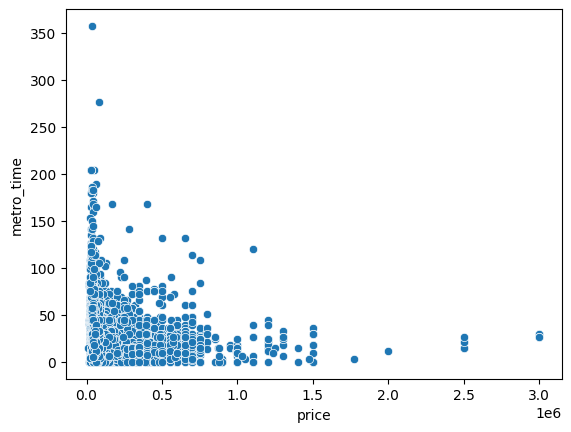

In [40]:
sns.scatterplot(data,x='price',y='metro_time')

<Axes: xlabel='price', ylabel='metro_time'>

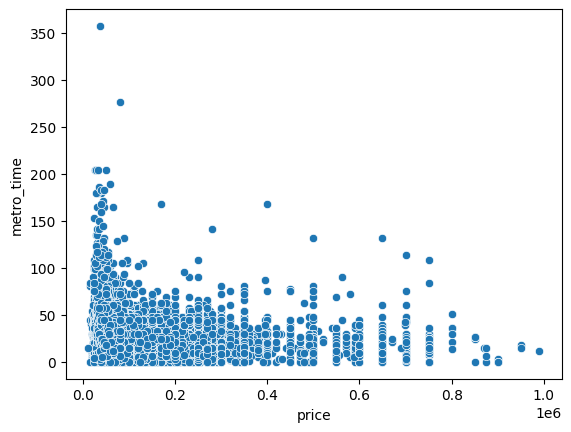

In [43]:
data=data[data['price']<1000000]
sns.scatterplot(data,x='price',y='metro_time')

<Axes: xlabel='col_rooms', ylabel='metro_time'>

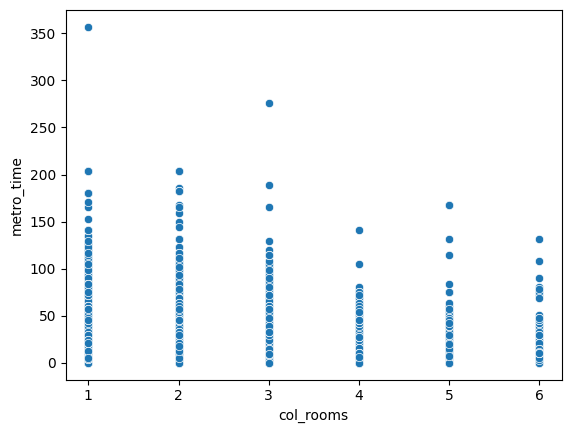

In [44]:
sns.scatterplot(data,x='col_rooms',y='metro_time')

In [46]:
data['metro_time'].mean()

26.52851888307517

In [30]:

#col_rooms
#ceiling_height
#var_room
#metro
#metro_time
#adress
#full_area
#kitchen_area
#living_area
#floor
#num_floors
#parking
#prolonged
#phone_number
#coord_y
#coord_x
#Furnished
#elevator
#garbage_chute
#repair
#balcony_count
#windows
#bathroom
#child_pet


In [31]:
#для получения координат по адресам
assert False

from geopy.geocoders import Nominatim
addarr= data['adress']
addrdic={}

def get_metro_station_coordinates(station_name):
    geolocator = Nominatim(user_agent="metro_locator")  

    # Добавим "метро" к запросу для более точного результата
    location = geolocator.geocode(f"{station_name} , Москва")

    if location:
        coordinates = (location.latitude, location.longitude)
        return coordinates
    else:
        print(f"Координаты для станции метро {station_name} не найдены.")
        return None

for i in addarr:
    try:
        if i in addrdic.keys():
            continue
        addrdic[i] = get_metro_station_coordinates(i)
    except:
        pass

with open('coordinates', 'wb') as file:
    pickle.dump(addrdic, file)



AssertionError: 